In [1]:
# se conecta al drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#instalación de pandas_plink
!pip install pandas_plink

In [3]:
import os

plink_file_path = '/content/drive/MyDrive/colaboracion brenda/Base datos'

# Listar archivos
files = os.listdir(plink_file_path)
for file in files:
    print(file)

Nuevo_intento (1) (1).html
Substances.nosex
Substances.bed
Substances.log
Substances.bim
Base de datos_machine learning.gsheet
ancestría_10PCA.gdoc
X_XGBoost.csv
labels_drugs.csv
umap_kmeans_panel.png
pca_resultados_filtrados.csv
anova_results.csv
bd.csv
pca_resultados.csv
Substances.fam


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2281369176.py:24: SyntaxWarning: invalid escape sequence '\s'
  fam = pd.read_csv(fam_path, sep='\s+', header=None)
/usr/local/lib/python3.12/dist-packages/pandera/_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPO

Resultados de PCA guardados en: /content/drive/MyDrive/colaboracion brenda/Base datos/pca_resultados.csv


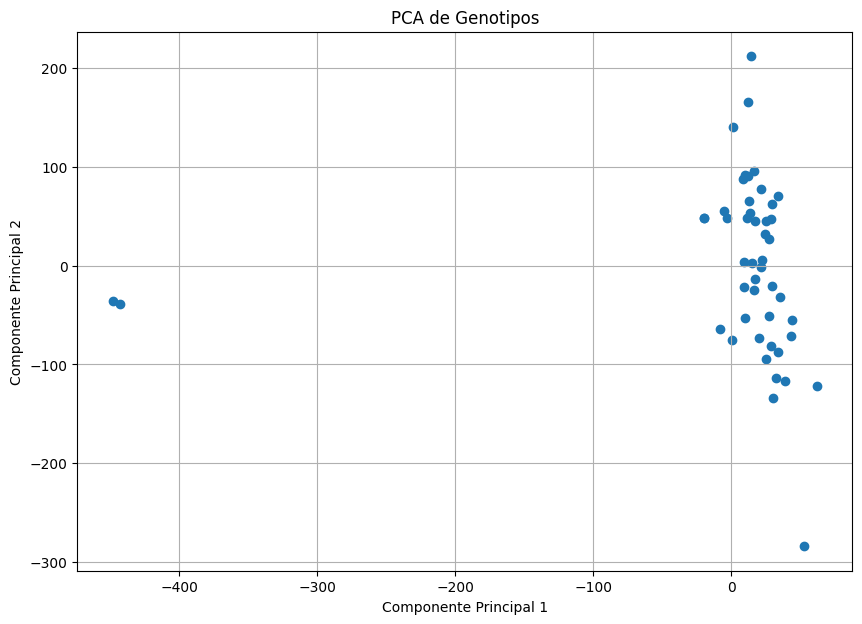

In [4]:
import pandas as pd
from pandas_plink import read_plink
import os
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ✅ Rutas EXPLÍCITAS a tus archivos
fam_path = '/content/drive/MyDrive/colaboracion brenda/Base datos/Substances.fam'
bim_path = '/content/drive/MyDrive/colaboracion brenda/Base datos/Substances.bim'
bed_path = '/content/drive/MyDrive/colaboracion brenda/Base datos/Substances.bed'

# ✅ Prefijo para read_plink
plink_prefix = fam_path.rsplit('.', 1)[0]  # Elimina la extensión para obtener el prefijo

# Verificar existencia de archivos (opcional)
for path in [fam_path, bim_path, bed_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró el archivo: {path}")

# Leer y limpiar el archivo .fam
fam = pd.read_csv(fam_path, sep='\s+', header=None)
fam.columns = ['fid', 'iid', 'father', 'mother', 'gender', 'trait']
fam_cleaned = fam.dropna(subset=['trait'])

# Guardar archivo limpio (opcional)
fam_cleaned.to_csv(fam_path, sep=' ', header=False, index=False)

# Leer datos PLINK con prefijo
(bim, fam, G) = read_plink(plink_prefix, verbose=False)

# Transponer matriz de genotipos y convertir a DataFrame
G_transposed = G.T.compute()
G_df = pd.DataFrame(G_transposed, columns=bim['snp'], index=fam['iid'])

# Filtrar SNPs con datos observados
cols_with_values = G_df.columns[G_df.notna().any()]
G_df_filtered = G_df[cols_with_values]

# Imputar valores faltantes
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
G_imputed = pd.DataFrame(imputer.fit_transform(G_df_filtered),
                         columns=G_df_filtered.columns,
                         index=G_df_filtered.index)

# Estandarizar
scaler = StandardScaler()
G_scaled = scaler.fit_transform(G_imputed)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(G_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=G_df.index)

# Guardar resultados
output_csv = '/content/drive/MyDrive/colaboracion brenda/Base datos/pca_resultados.csv'
pca_df.to_csv(output_csv)
print(f"Resultados de PCA guardados en: {output_csv}")

# Graficar
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de Genotipos')
plt.grid()
plt.show()


In [5]:
G_scaled.shape

(48, 288771)

In [6]:
# Mostrar las primeras filas de los DataFrames 'bim' y 'fam'
print("Contenido del archivo .bim:")
print(bim.head(), "\n")
print("Contenido del archivo .fam después de leer con read_plink:")
print(fam.head(), "\n")

# Obtener la cantidad de muestras y SNPs
num_samples = fam.shape[0]
num_snps = bim.shape[0]
print(f"Número de muestras: {num_samples}")
print(f"Número de SNPs: {num_snps}\n")

Contenido del archivo .bim:
  chrom            snp   cm     pos a0 a1  i
0     1      rs3131972  0.0  752721  T  C  0
1     1      rs4970383  0.0  838555  T  G  1
2     1      rs4970382  0.0  840753  A  G  2
3     1  GSA-rs4475691  0.0  846808  T  C  3
4     1      rs7537756  0.0  854250  G  A  4 

Contenido del archivo .fam después de leer con read_plink:
  fid      iid father mother gender trait  i
0   2  PGSI210      0      0      0    -9  0
1   3  PGSI410      0      0      0    -9  1
2   6  PGSI411      0      0      0    -9  2
3   7  PGSI524      0      0      0    -9  3
4   8  PGSI004      0      0      0    -9  4 

Número de muestras: 48
Número de SNPs: 288567



In [7]:
fam['trait'].unique() # no hay grupo control...

<StringArray>
['-9']
Length: 1, dtype: string

In [8]:
# 1. Extrae el listado de variables (SNPs) usadas en el PCA
snp_usados = G_imputed.columns

# 2. Filtra el DataFrame 'bim' para quedarte solo con los SNPs realmente usados
bim_usados = bim[bim['snp'].isin(snp_usados)].copy()

# 3. Opcional: ordena bim_usados igual que en G_imputed (si quieres el mismo orden)
bim_usados = bim_usados.set_index('snp').loc[snp_usados].reset_index()

# 4. Visualiza el DataFrame con regiones y SNPs
print(bim_usados.head())


             snp chrom   cm     pos a0 a1  i
0      rs3131972     1  0.0  752721  T  C  0
1      rs4970383     1  0.0  838555  T  G  1
2      rs4970382     1  0.0  840753  A  G  2
3  GSA-rs4475691     1  0.0  846808  T  C  3
4      rs7537756     1  0.0  854250  G  A  4


In [9]:
# Asegúrate de que el índice de G_imputed son los IDs de muestra
X = G_imputed.copy()
X.index.name = 'iid'  # Opcional: nombra el índice
print(X.shape)
print(X.head())

# Guarda el DataFrame X listo para XGBoost
X

(48, 288771)
snp      rs3131972  rs4970383  rs4970382  GSA-rs4475691  rs7537756  \
iid                                                                  
PGSI210        2.0        2.0        1.0            1.0        1.0   
PGSI410        2.0        2.0        1.0            2.0        2.0   
PGSI411        1.0        1.0        1.0            1.0        1.0   
PGSI524        1.0        2.0        2.0            1.0        1.0   
PGSI004        2.0        2.0        2.0            1.0        1.0   

snp      rs13302982  rs2880024  rs2272757  rs13303010  rs3935066  ...  \
iid                                                               ...   
PGSI210         2.0        1.0        1.0         2.0        2.0  ...   
PGSI410         2.0        0.0        2.0         2.0        2.0  ...   
PGSI411         2.0        1.0        0.0         2.0        2.0  ...   
PGSI524         2.0        2.0        1.0         2.0        2.0  ...   
PGSI004         2.0        2.0        0.0         1.0     

snp,rs3131972,rs4970383,rs4970382,GSA-rs4475691,rs7537756,rs13302982,rs2880024,rs2272757,rs13303010,rs3935066,...,rs28357371,rs2853510,rs35134837,rs35134837,rs35134837,rs35134837,rs386829288,rs62581341,rs34301918,rs3937033
iid,,,,,,,,,,,,,,,,,,,,,
PGSI210,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
PGSI410,2.0,2.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
PGSI411,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI524,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0
PGSI004,2.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,...,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI106,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
PGSI002,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI215,2.0,2.0,0.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI103,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0


In [10]:
df = pd.read_csv(
    '/content/drive/MyDrive/colaboracion brenda/Base datos/labels_drugs.csv',
    encoding='latin-1',
    sep=';'
).set_index('PGSI (o IID)')

# Elimina filas con al menos un NaN en cualquier columna
df_clean = df.dropna(axis=1)

print(df_clean.shape)
print(df_clean.head())


(42, 5)
              TOBACCO  ALCOHOL  MARIJUANA  COCAINE  METHAMPHETAMINES
PGSI (o IID)                                                        
PGSI002             1        1          1        0                 1
PGSI003             1        1          1        0                 0
PGSI004             1        1          1        1                 1
PGSI005             1        1          1        0                 1
PGSI006             0        0          1        0                 0


In [11]:
df_clean

,TOBACCO,ALCOHOL,MARIJUANA,COCAINE,METHAMPHETAMINES
PGSI (o IID),,,,,
PGSI002,1,1,1,0,1
PGSI003,1,1,1,0,0
PGSI004,1,1,1,1,1
PGSI005,1,1,1,0,1
PGSI006,0,0,1,0,0
PGSI007,1,1,1,0,0
PGSI009,0,0,1,0,0
PGSI101,1,1,1,1,1
PGSI103,1,1,1,1,1


In [12]:
df = pd.read_csv(
    '/content/drive/MyDrive/colaboracion brenda/Base datos/bd.csv', sep=','
).set_index('PGSI (o IID)')
df # SUSTANCIAS UTILIZADAS

,SEXO,EDAD,Socioeconomic_level,TABACO,ALCOHOL,MARIHUANA,COCAÍNA,METANFETAMINAS,# SUSTANCIAS UTILIZADAS,Depression,Anxiety,Stress,ICAST_Neglect,ICAST_Psy_abuse,ICAST_Phy Abuse,ICAST_Sexual_abuse,ACEIQ
PGSI (o IID),,,,,,,,,,,,,,,,,
PGSI002,1,17,5.0,1,1,1,0,1,4,0.0,0.0,0.0,2,7,8,2,12.0
PGSI003,1,16,3.0,1,1,1,0,0,3,1.0,2.0,1.0,2,4,6,1,11.0
PGSI004,1,57,7.0,1,1,1,1,1,5,2.0,2.0,0.0,4,7,1,0,10.0
PGSI005,2,21,4.0,1,1,1,0,1,4,3.0,4.0,2.0,6,3,6,1,8.0
PGSI006,1,20,3.0,0,0,1,0,0,1,3.0,4.0,1.0,9,7,9,4,9.0
PGSI007,1,16,2.0,1,1,1,0,0,3,2.0,2.0,0.0,4,4,4,0,NaN
PGSI009,1,14,2.0,0,0,1,0,0,1,0.0,0.0,0.0,2,0,0,0,0.0
PGSI101,1,46,4.0,1,1,1,1,1,5,2.0,2.0,0.0,2,4,0,0,8.0
PGSI103,2,52,4.0,1,1,1,1,1,5,4.0,4.0,3.0,5,7,7,0,27.0


In [13]:
!pip install gower

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


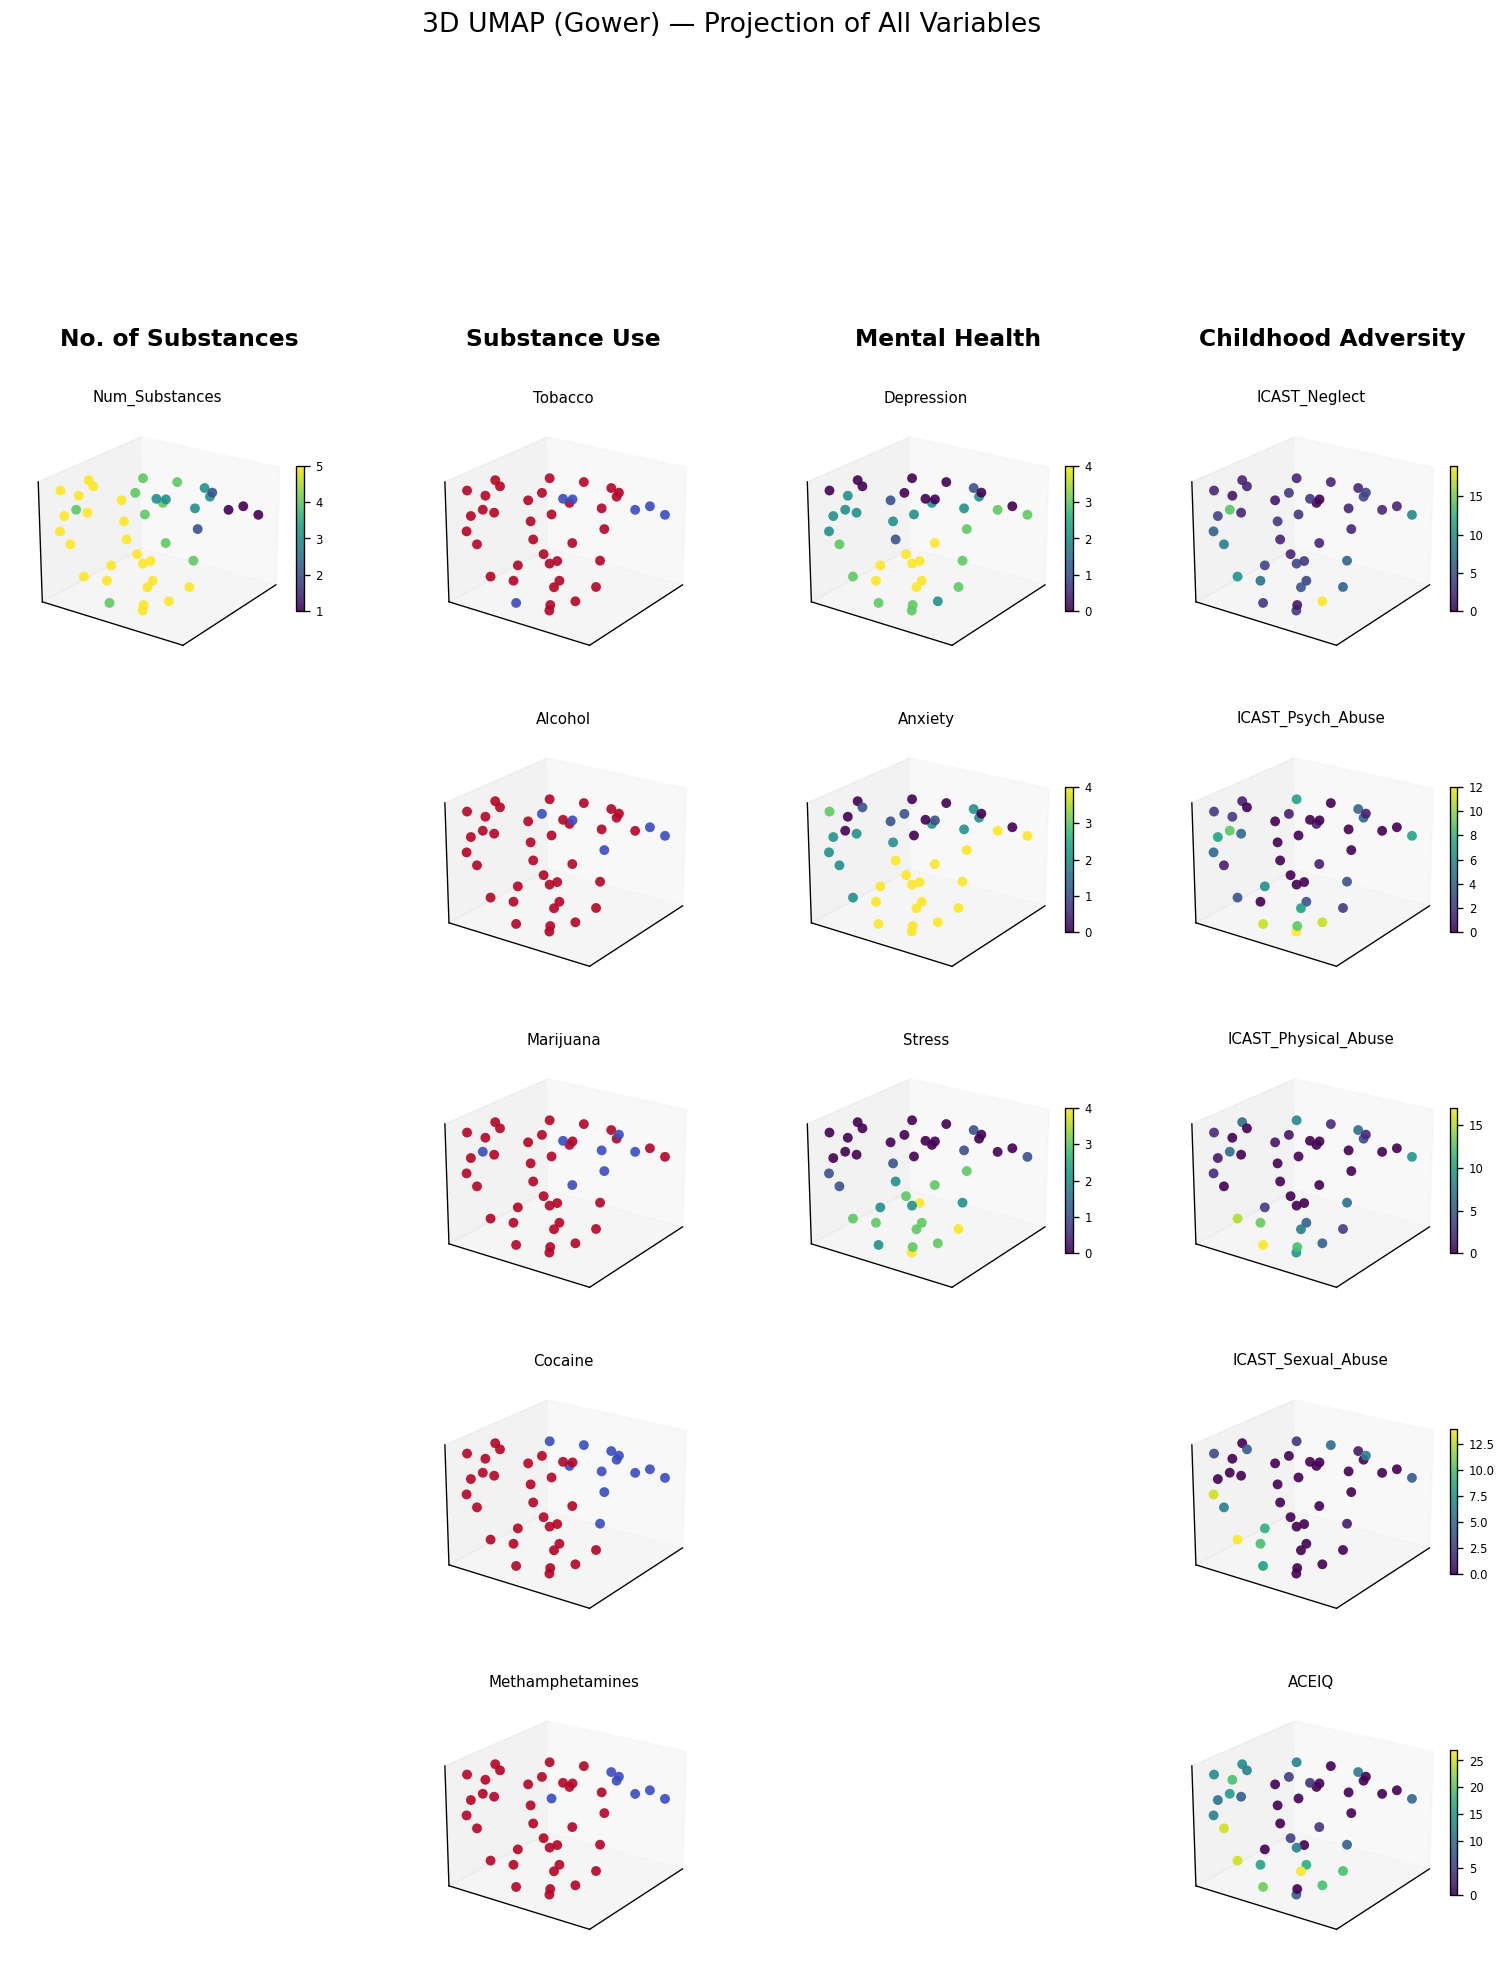

In [14]:
import pandas as pd
import numpy as np
import gower
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ------------------------------
# Rename columns to English-friendly names
# ------------------------------
rename_dict = {
    'TABACO': 'Tobacco',
    'ALCOHOL': 'Alcohol',
    'MARIHUANA': 'Marijuana',
    'COCAÍNA': 'Cocaine',
    'METANFETAMINAS': 'Methamphetamines',
    '# SUSTANCIAS UTILIZADAS': 'Num_Substances',
    'Depression': 'Depression',
    'Anxiety': 'Anxiety',
    'Stress': 'Stress',
    'ICAST_Neglect': 'ICAST_Neglect',
    'ICAST_Psy_abuse': 'ICAST_Psych_Abuse',
    'ICAST_Phy Abuse': 'ICAST_Physical_Abuse',
    'ICAST_Sexual_abuse': 'ICAST_Sexual_Abuse',
    'ACEIQ': 'ACEIQ'
}
df_ren = df.rename(columns=rename_dict)

consumption = ['Tobacco','Alcohol','Marijuana','Cocaine','Methamphetamines']
mental      = ['Depression','Anxiety','Stress']
adversity   = ['ICAST_Neglect','ICAST_Psych_Abuse','ICAST_Physical_Abuse','ICAST_Sexual_Abuse','ACEIQ']
extra       = ['Num_Substances']

blocks = {
    "No. of Substances": extra,
    "Substance Use": consumption,
    "Mental Health": mental,
    "Childhood Adversity": adversity
}

cols = sum(blocks.values(), [])
df_clean = df_ren[cols].copy().fillna(0)

# ------------------------------
# 1. Gower distance
# ------------------------------
D = gower.gower_matrix(df_clean)

# ------------------------------
# 2. UMAP 3D (precomputed metric)
# ------------------------------
umap_model = umap.UMAP(n_components=3, metric='precomputed', random_state=42)
umap_embedding = umap_model.fit_transform(D)

# ------------------------------
# Helpers
# ------------------------------
def is_binary(series):
    vals = pd.unique(series.dropna())
    return set(vals).issubset({0, 1})

# ------------------------------
# 3. Compact figure with GridSpec
# ------------------------------
nrows = max(len(extra), len(consumption), len(mental), len(adversity))
ncols = len(blocks)

fig_width = 4 * ncols
fig_height = 3.2 * (nrows + 0.5)
fig = plt.figure(figsize=(fig_width, fig_height), dpi=120)

gs = gridspec.GridSpec(
    nrows + 1, ncols,
    height_ratios=[0.08] + [1]*nrows,
    wspace=0.15, hspace=0.25
)

# Column headers
for j, title in enumerate(blocks.keys()):
    axh = fig.add_subplot(gs[0, j])
    axh.axis('off')
    axh.text(0.5, 0.5, title, ha='center', va='center',
             fontsize=14, fontweight='bold')

# Function to fill each cell
def add_cell(i, j, varlist):
    ax = fig.add_subplot(gs[i+1, j], projection='3d')
    if i < len(varlist):
        var = varlist[i]
        vals = df_clean[var]
        cmap = plt.get_cmap('coolwarm', 2) if is_binary(vals) else 'viridis'

        sc = ax.scatter(
            umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2],
            c=vals, cmap=cmap, s=35, alpha=0.9, edgecolor='none'
        )
        ax.set_title(var, fontsize=9, pad=2)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
        ax.view_init(elev=22, azim=35)

        if not is_binary(vals):
            cb = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
            cb.ax.tick_params(labelsize=7)
            if var == 'Num_Substances':
                min_n, max_n = int(vals.min()), int(vals.max())
                cb.set_ticks(range(min_n, max_n+1))
    else:
        ax.axis('off')

# Fill figure
for j, varlist in enumerate(blocks.values()):
    for i in range(nrows):
        add_cell(i, j, varlist)

plt.suptitle('3D UMAP (Gower) — Projection of All Variables', fontsize=16, y=1.03)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


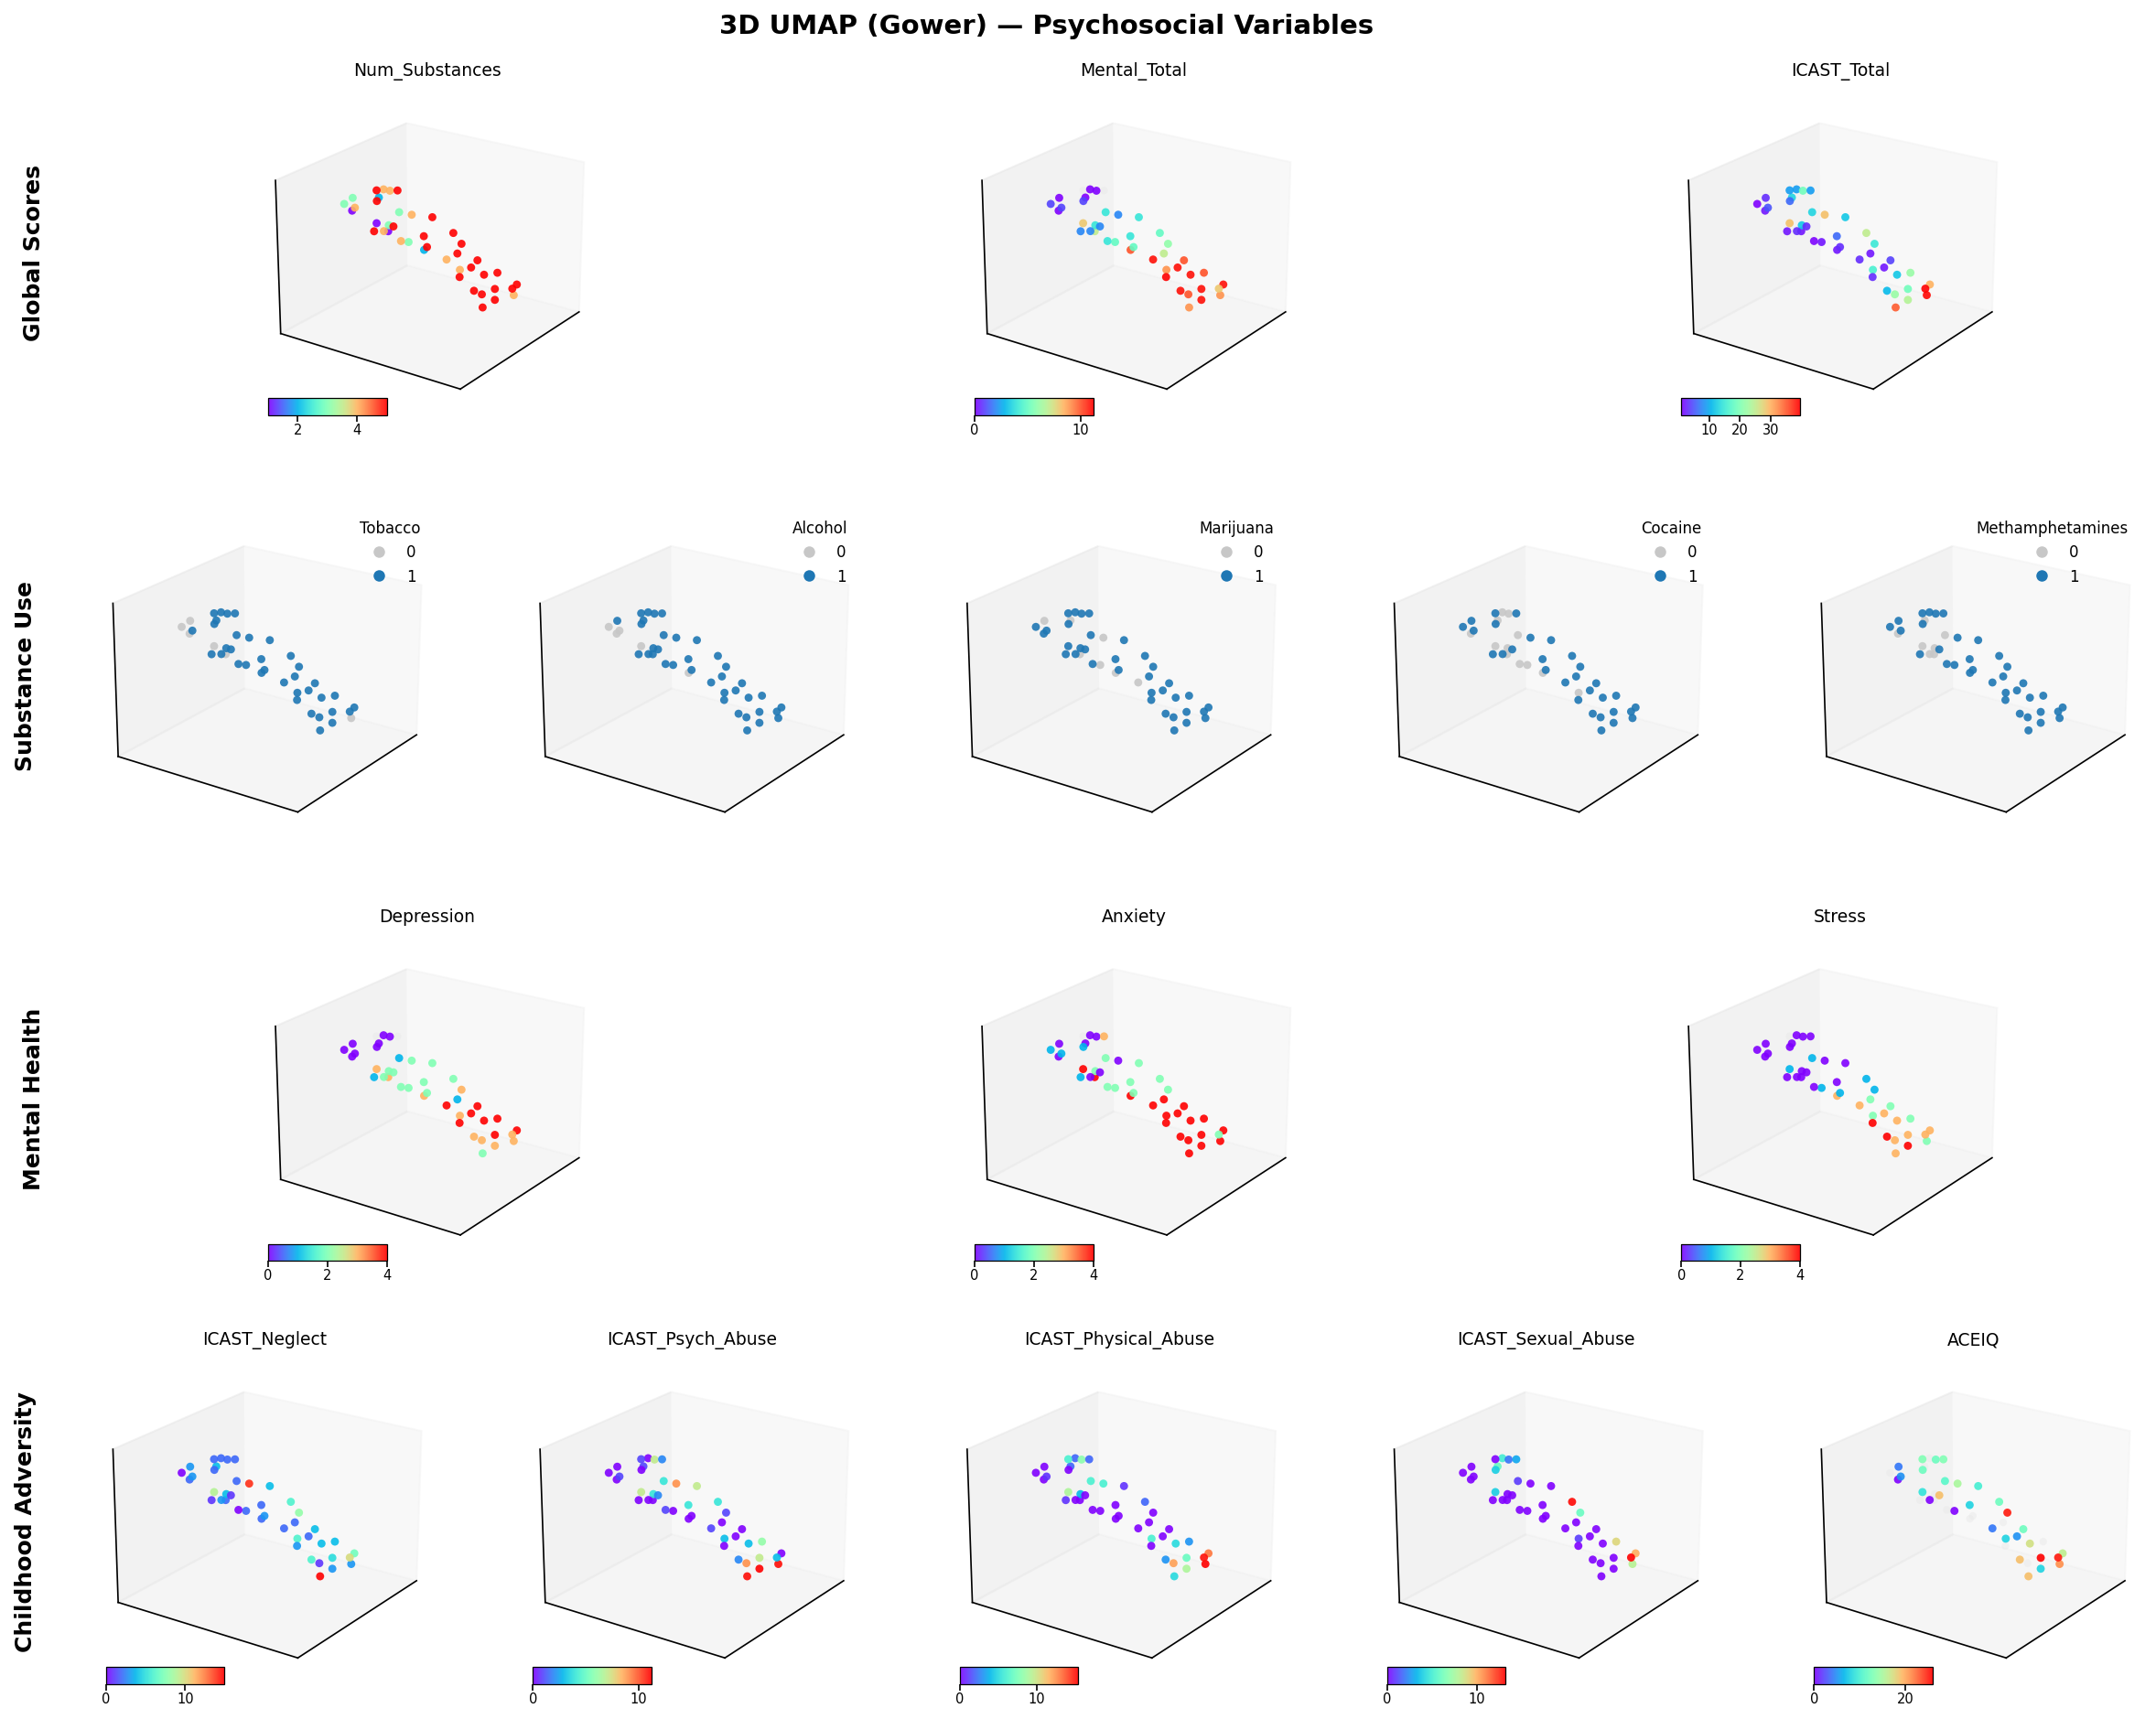

In [15]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import umap.umap_ as umap
import gower

# ==============================
# 1) Configuración estética global (paper-ready)
# ==============================
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 9,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "axes.titlepad": 4.0
})

# ==============================
# 2) Renombrar y totales
# ==============================
rename_dict = {
    'TABACO': 'Tobacco',
    'ALCOHOL': 'Alcohol',
    'MARIHUANA': 'Marijuana',
    'COCAÍNA': 'Cocaine',
    'METANFETAMINAS': 'Methamphetamines',
    '# SUSTANCIAS UTILIZADAS': 'Num_Substances',
    'Depression': 'Depression',
    'Anxiety': 'Anxiety',
    'Stress': 'Stress',
    'ICAST_Neglect': 'ICAST_Neglect',
    'ICAST_Psy_abuse': 'ICAST_Psych_Abuse',
    'ICAST_Phy Abuse': 'ICAST_Physical_Abuse',
    'ICAST_Sexual_abuse': 'ICAST_Sexual_Abuse',
    'ACEIQ': 'ACEIQ'
}
df_ren = df.rename(columns=rename_dict).copy()

# Totales
df_ren['ICAST_Total'] = (
    df_ren['ICAST_Neglect'] +
    df_ren['ICAST_Psych_Abuse'] +
    df_ren['ICAST_Physical_Abuse'] +
    df_ren['ICAST_Sexual_Abuse']
)
df_ren['Mental_Total'] = (
    df_ren['Depression'] +
    df_ren['Anxiety'] +
    df_ren['Stress']
)

# ==============================
# 3) Definir bloques y columnas a usar
# ==============================
blocks = {
    "Global Scores": ['Num_Substances', 'Mental_Total', 'ICAST_Total'],
    "Substance Use": ['Tobacco','Alcohol','Marijuana','Cocaine','Methamphetamines'],
    "Mental Health": ['Depression','Anxiety','Stress'],
    "Childhood Adversity": ['ICAST_Neglect','ICAST_Psych_Abuse','ICAST_Physical_Abuse','ICAST_Sexual_Abuse','ACEIQ']
}

all_cols = [c for cols in blocks.values() for c in cols]
df_clean = df_ren[all_cols].copy()

# ==============================
# 4) Distancias Gower + UMAP 3D
# ==============================
# Para colorear, NO forzamos NaNs a 0; para cálculo de Gower sí sustituimos faltantes por 0
# (Gower tolera mixtos y esta sustitución es razonable para la métrica; ajusta si requieres otra política).
D = gower.gower_matrix(df_clean.fillna(0))
umap_model = umap.UMAP(
    n_components=3,
    metric='precomputed',
    random_state=42,

)
emb = umap_model.fit_transform(D)  # shape (n, 3)

# ==============================
# 5) Helpers
# ==============================
def is_binary(series: pd.Series) -> bool:
    """True si la variable es binaria (solo 0/1, ignorando NaNs)."""
    vals = pd.unique(series.dropna())
    return len(vals) > 0 and set(vals).issubset({0, 1})

def robust_norm(x: pd.Series, q_low=2, q_high=98):
    """Normalización robusta por percentiles para color mapping."""
    x_nonan = x.dropna().to_numpy()
    if x_nonan.size == 0:
        return Normalize(vmin=0, vmax=1)
    vmin = np.percentile(x_nonan, q_low)
    vmax = np.percentile(x_nonan, q_high)
    if np.isclose(vmin, vmax):
        vmax = vmin + 1e-6
    return Normalize(vmin=vmin, vmax=vmax)

# Paleta binaria sobria (gris para 0, azul para 1)
binary_cmap = ListedColormap(["#c7c7c7", "#1f77b4"])

# ==============================
# 6) Figura con subgridspec por fila (sin huecos)
# ==============================
nrows = len(blocks)
fig = plt.figure(figsize=(1.6 + 3.1*max(len(v) for v in blocks.values()), 3.2*nrows))
outer_gs = fig.add_gridspec(nrows=nrows, ncols=1, hspace=0.25)

view_elev, view_azim = 22, 35  # Vista 3D consistente

for r, (block_title, variables) in enumerate(blocks.items()):
    # subgrid: 1 col para encabezado + N variables
    sub_gs = outer_gs[r].subgridspec(
        nrows=1,
        ncols=len(variables) + 1,
        width_ratios=[0.06] + [1]*len(variables),
        wspace=0.08
    )

    # --- Columna de encabezado (texto vertical centrado) ---
    ax_head = fig.add_subplot(sub_gs[0, 0])
    ax_head.axis("off")
    ax_head.text(
        0.5, 0.5, block_title,
        ha="center", va="center", rotation=90,
        fontsize=12, fontweight="bold"
    )

    # --- Columnas de variables ---
    for c, var in enumerate(variables, start=1):
        ax = fig.add_subplot(sub_gs[0, c], projection='3d')

        vals = df_clean[var]
        mask = ~vals.isna()
        if mask.sum() == 0:
            # Nada que colorear (todo NaN)
            ax.scatter(emb[:,0], emb[:,1], emb[:,2],
                       s=18, alpha=0.45, edgecolor='none', c="#d9d9d9")
            ax.set_title(var)
        else:
            if is_binary(vals):
                # Binaria: leyenda en vez de colorbar
                colors = vals.map({0: binary_cmap(0), 1: binary_cmap(1)})
                sc = ax.scatter(
                    emb[mask,0], emb[mask,1], emb[mask,2],
                    c=colors[mask], s=18, alpha=0.9, edgecolor='none'
                )
                # Puntos grises claros para los NaN, si existen
                if (~mask).any():
                    ax.scatter(
                        emb[~mask,0], emb[~mask,1], emb[~mask,2],
                        c="#e6e6e6", s=16, alpha=0.5, edgecolor='none'
                    )
                # Leyenda compacta (0/1 y opcional NaN)
                legend_elems = [
                    Line2D([0],[0], marker='o', linestyle='',
                           markerfacecolor=binary_cmap(0), markeredgecolor='none',
                           markersize=6, label='0'),
                    Line2D([0],[0], marker='o', linestyle='',
                           markerfacecolor=binary_cmap(1), markeredgecolor='none',
                           markersize=6, label='1')
                ]
                if (~mask).any():
                    legend_elems.append(
                        Line2D([0],[0], marker='o', linestyle='',
                               markerfacecolor="#e6e6e6", markeredgecolor='none',
                               markersize=6, label='NaN')
                    )
                ax.legend(handles=legend_elems, loc='upper right', frameon=False, title=var, title_fontsize=8)
                ax.set_title("")  # título ya en la leyenda
            else:
                # Continua: colorbar pequeño embebido
                norm = robust_norm(vals)
                sc = ax.scatter(
                    emb[mask,0], emb[mask,1], emb[mask,2],
                    c=vals[mask], cmap='rainbow', norm=norm,
                    s=18, alpha=0.9, edgecolor='none'
                )
                # NaNs (si hay) como puntos apagados
                if (~mask).any():
                    ax.scatter(
                        emb[~mask,0], emb[~mask,1], emb[~mask,2],
                        c="#e6e6e6", s=16, alpha=0.4, edgecolor='none'
                    )
                ax.set_title(var)

                # Colorbar delgada dentro del eje (no reduce el tamaño del scatter)
                cax = inset_axes(ax, width="35%", height="5%", loc='lower left',
                                 bbox_to_anchor=(0.03, 0.02, 1, 1),
                                 bbox_transform=ax.transAxes, borderpad=0)
                cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
                cb.ax.tick_params(labelsize=7, pad=0.5)
                cb.outline.set_linewidth(0.6)

        # Limpieza del eje 3D
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
        ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("")
        ax.view_init(elev=view_elev, azim=view_azim)
        # Límites iguales para evitar distorsión visual
        xyz_min = emb.min(axis=0); xyz_max = emb.max(axis=0)
        centers = (xyz_min + xyz_max)/2.0
        spans = (xyz_max - xyz_min).max()
        ax.set_xlim(centers[0]-spans/2, centers[0]+spans/2)
        ax.set_ylim(centers[1]-spans/2, centers[1]+spans/2)
        ax.set_zlim(centers[2]-spans/2, centers[2]+spans/2)

# Título global
fig.suptitle("3D UMAP (Gower) — Psychosocial Variables", y=0.995, fontsize=14, fontweight='bold')

# Ajustes finales: bordes y márgenes
plt.subplots_adjust(top=0.955, left=0.06, right=0.98, bottom=0.04)

# Guardado listo para paper
plt.savefig("umap_gower_psychosocial_grid.png", bbox_inches="tight", pad_inches=0.05)
plt.savefig("umap_gower_psychosocial_grid.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()


/tmp/ipython-input-2359037065.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.96])
/tmp/ipython-input-2359037065.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.96])


[OK] KMeans(K=2) — silhouette=0.628
Tamaños por clúster: {0: 17, 1: 25}
Columna añadida a X: kmeans2

Primeras filas de X con etiquetas K-Means:
              Num_Substances  Mental_Total  ICAST_Total  Tobacco  Alcohol  \
PGSI (o IID)                                                                
PGSI002                    4           0.0           19        1        1   
PGSI003                    3           4.0           13        1        1   
PGSI004                    5           4.0           12        1        1   
PGSI005                    4           9.0           16        1        1   
PGSI006                    1           8.0           29        0        0   

              Marijuana  Cocaine  Methamphetamines  Depression  Anxiety  \
PGSI (o IID)                                                              
PGSI002               1        0                 1         0.0      0.0   
PGSI003               1        0                 0         1.0      2.0   
PGSI004        

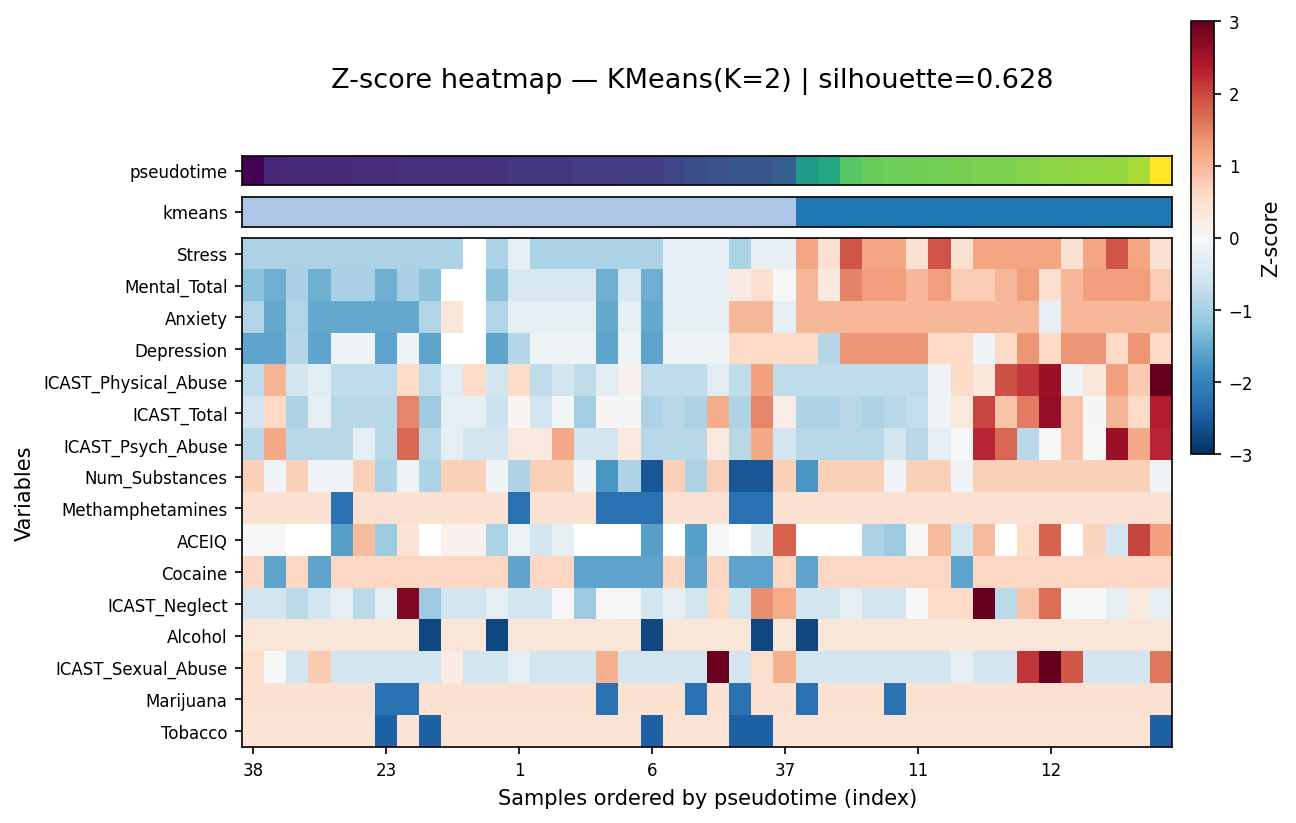

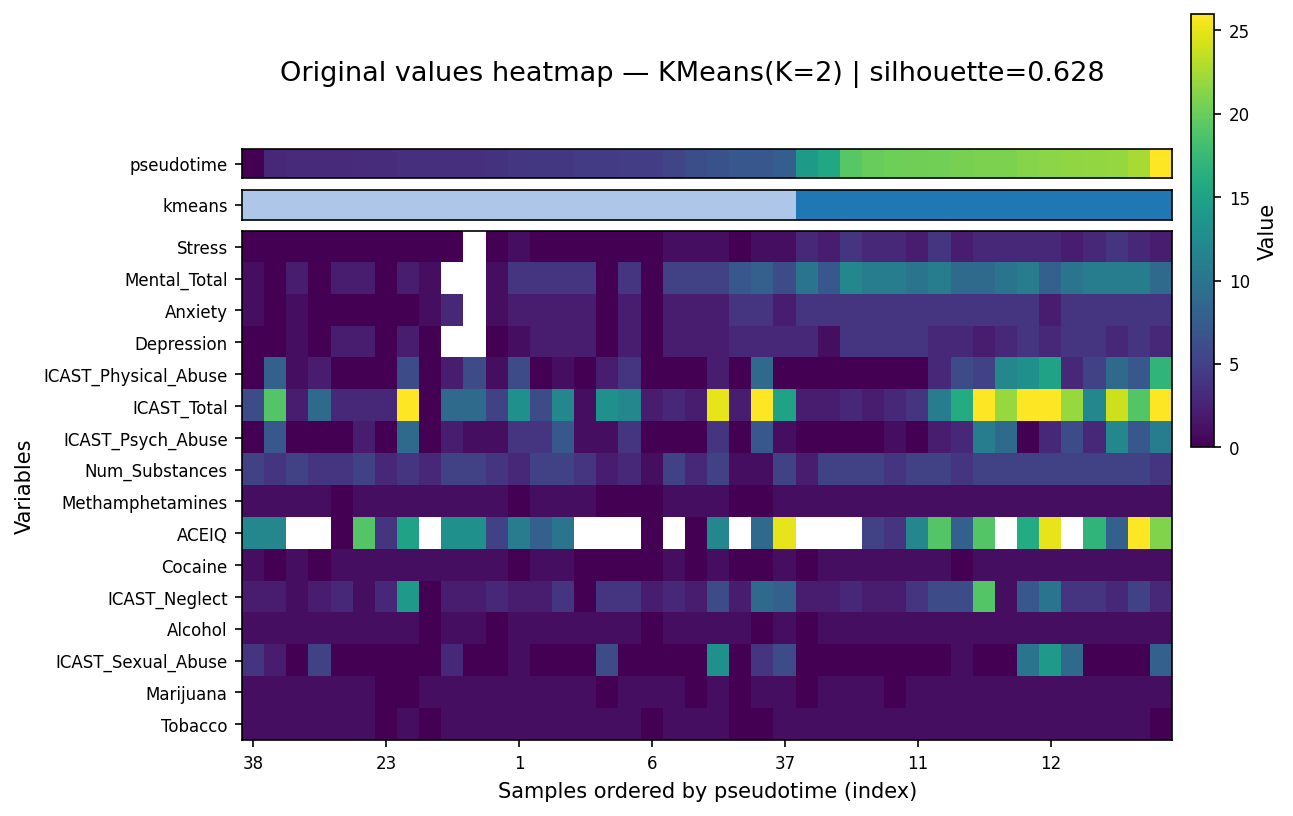

In [32]:
# -*- coding: utf-8 -*-
# === ALL-IN-ONE ===
# K-Means (K=3) sobre el embedding `emb`, pseudotime, 2 heatmaps (Z-score / original)
# con franja y leyenda de clústeres, y adjunta la columna kmeans3 a X.

import numpy as np
import pandas as pd

# Vecindarios / caminos
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ------------------------------------------------------------------------------------
# 0) Opcional — ajustes estéticos
# ------------------------------------------------------------------------------------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 300,
    "font.size": 10, "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8
})

# ------------------------------------------------------------------------------------
# 1) Grafo kNN y pseudotiempo por Random Walk
# ------------------------------------------------------------------------------------
def build_knn_graph(emb: np.ndarray, k: int = 15, sigma: float | None = None):
    """Devuelve matriz de transición P (fila-estocástica) y pesos W (simétrica)."""
    n = emb.shape[0]
    nbrs = NearestNeighbors(n_neighbors=min(k+1, n)).fit(emb)
    dists, inds = nbrs.kneighbors(emb)
    # quitar el self-neighbor
    inds, dists = inds[:, 1:], dists[:, 1:]

    if sigma is None:
        med = np.median(dists[np.isfinite(dists)])
        sigma = med if (np.isfinite(med) and med > 0) else 1.0

    W_data = np.exp(-(dists**2) / (2 * sigma**2))
    rows = np.repeat(np.arange(n), inds.shape[1])
    cols = inds.reshape(-1)
    data = W_data.reshape(-1)

    W = csr_matrix((data, (rows, cols)), shape=(n, n))
    W = 0.5 * (W + W.T)  # simetrizar

    row_sums = np.asarray(W.sum(axis=1)).ravel()
    row_sums[row_sums == 0] = 1.0
    Dinv = csr_matrix((1.0/row_sums, (np.arange(n), np.arange(n))), shape=(n, n))
    P = Dinv @ W
    return P, W

def random_walk_pseudotime(P: csr_matrix, start_idx: int, end_idx: int,
                           n_walks: int = 400, max_steps: int = 4000, seed: int = 42):
    """Tiempo promedio de primera visita (aprox) desde start hasta cada nodo, recorriendo hasta end."""
    rng = np.random.default_rng(seed)
    n = P.shape[0]
    indptr, indices, data = P.indptr, P.indices, P.data
    first_hit_sum = np.zeros(n, dtype=float)
    first_hit_count = np.zeros(n, dtype=int)

    for _ in range(n_walks):
        curr = start_idx
        visited_time = {}
        for step in range(max_steps):
            if curr not in visited_time:
                visited_time[curr] = step
            if curr == end_idx:
                break
            L, R = indptr[curr], indptr[curr+1]
            neigh, probs = indices[L:R], data[L:R]
            if neigh.size == 0:
                break
            curr = rng.choice(neigh, p=probs / probs.sum())

        for node, t in visited_time.items():
            first_hit_sum[node] += t
            first_hit_count[node] += 1

    pseudo_t = np.full(n, np.inf)
    mask = first_hit_count > 0
    pseudo_t[mask] = first_hit_sum[mask] / first_hit_count[mask]
    return pseudo_t

def fill_inf_with_geodesic(pseudo_t: np.ndarray, W: csr_matrix, start_idx: int):
    """Rellena ∞ en pseudotiempo usando distancia geodésica en el grafo (1/weight)."""
    W_coo = W.tocoo()
    costs = 1.0 / np.maximum(W_coo.data, 1e-12)
    G = csr_matrix((costs, (W_coo.row, W_coo.col)), shape=W_coo.shape)
    dist = shortest_path(G, directed=False, indices=start_idx)
    dist = np.array(dist, dtype=float)
    finite = dist[np.isfinite(dist)]
    if finite.size == 0:
        return pseudo_t
    dmin, dmax = np.percentile(finite, [1, 99])
    if dmax <= dmin:
        dmax = dmin + 1.0
    dist_norm = (dist - dmin) / (dmax - dmin)
    dist_norm[~np.isfinite(dist_norm)] = np.nanmax(dist_norm[np.isfinite(dist_norm)]) if np.isfinite(dist_norm).any() else 1.0

    out = pseudo_t.copy()
    inf_mask = ~np.isfinite(out)
    base = np.nanmax(out[np.isfinite(out)]) if np.isfinite(out).any() else 0.0
    out[inf_mask] = base + (dist_norm[inf_mask] + 0.5) * 10.0
    return out

# ------------------------------------------------------------------------------------
# 2) Heatmap Matplotlib con franja de pseudotiempo + franja de clúster (y leyenda)
# ------------------------------------------------------------------------------------
def matplotlib_pseudotime_heatmap(
    X_ord: pd.DataFrame,
    pt_sorted_idx: np.ndarray,
    pt_norm_sorted: np.ndarray,
    *,
    cluster_sorted: np.ndarray | None = None,
    cluster_names: dict[int, str] | None = None,
    standardize: str = "zscore",      # "zscore" | "minmax" | "none"
    z_cap: float = 3.0,
    xtick_every: int = 8,
    cmap_heat: str = "RdBu_r",
    cmap_pt: str = "viridis",
    invert_x: bool = False,
    robust_percentiles: tuple[int, int] | None = None
):
    # --- matriz para pintar ---
    if standardize == "zscore":
        X_plot = (X_ord - X_ord.mean()) / (X_ord.std(ddof=0) + 1e-8)
        X_plot = X_plot.clip(lower=-z_cap, upper=z_cap)
        norm = mpl.colors.TwoSlopeNorm(vmin=-z_cap, vcenter=0.0, vmax=z_cap)
        cbar_label, cmap = "Z-score", cmap_heat
    elif standardize == "minmax":
        X_plot = (X_ord - X_ord.min()) / (X_ord.max() - X_ord.min() + 1e-12)
        norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
        cbar_label, cmap = "Min–Max", "viridis"
    else:
        X_plot = X_ord.copy()
        if robust_percentiles is not None:
            lo, hi = np.nanpercentile(X_plot.to_numpy(), robust_percentiles)
            norm = mpl.colors.Normalize(vmin=lo, vmax=hi)
        else:
            vmin, vmax = np.nanmin(X_plot.to_numpy()), np.nanmax(X_plot.to_numpy())
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_label, cmap = "Value", "viridis"

    n_samples, n_vars = X_plot.shape

    # --- layout ---
    n_stripes = 1 + (1 if cluster_sorted is not None else 0)
    ratios = [0.7] * n_stripes + [12]
    fig_w = max(8.0, n_samples / 28)
    fig_h = max(4.5, 1.1 + 0.22 * n_vars + 0.25 * n_stripes)

    fig = plt.figure(figsize=(fig_w, fig_h))
    gs  = mpl.gridspec.GridSpec(nrows=n_stripes + 1, ncols=1, height_ratios=ratios, hspace=0.06)

    # pseudotime stripe
    ax_pt = fig.add_subplot(gs[0, 0])
    ax_pt.imshow(pt_norm_sorted[np.newaxis, :], aspect="auto", cmap=cmap_pt, vmin=0.0, vmax=1.0)
    ax_pt.set_yticks([0]); ax_pt.set_yticklabels(["pseudotime"])
    ax_pt.set_xticks([])

    axes_to_flip = [ax_pt]

    # cluster stripe + leyenda
    if cluster_sorted is not None:
        ax_cl = fig.add_subplot(gs[1, 0])
        uniq = sorted(np.unique(cluster_sorted))
        base = plt.get_cmap("tab20").colors
        reps = (len(uniq) // len(base)) + 1
        palette = (base * reps)[:len(uniq)]
        label_to_color = {k: palette[i] for i, k in enumerate(uniq)}
        color_row = np.array([label_to_color[int(k)] for k in cluster_sorted])
        ax_cl.imshow(color_row[np.newaxis, :, :], aspect="auto")
        ax_cl.set_yticks([0]); ax_cl.set_yticklabels(["kmeans"])
        ax_cl.set_xticks([])
        axes_to_flip.append(ax_cl)

        # nombres amigables
        if cluster_names is None:
            cluster_names = {k: f"Cluster {k}" for k in uniq}
        legend_handles = [Patch(facecolor=label_to_color[k], edgecolor='none',
                                label=cluster_names.get(k, f"Cluster {k}")) for k in uniq]
        ax_cl.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(0, -0.35),
                     frameon=False, ncols=min(len(uniq), 8))

    # heatmap principal
    ax_hm = fig.add_subplot(gs[n_stripes, 0])
    im = ax_hm.imshow(X_plot.values.T, aspect="auto", cmap=cmap, norm=norm)

    if invert_x:
        for ax in axes_to_flip: ax.invert_xaxis()
        ax_hm.invert_xaxis()

    ax_hm.set_yticks(np.arange(n_vars))
    ax_hm.set_yticklabels(list(X_plot.columns))
    tick_pos = np.arange(0, n_samples, max(1, int(xtick_every)))
    ax_hm.set_xticks(tick_pos)
    ax_hm.set_xticklabels([str(pt_sorted_idx[i]) for i in tick_pos], fontsize=8)
    ax_hm.set_xlabel("Samples ordered by pseudotime (index)")
    ax_hm.set_ylabel("Variables")

    # colorbar
    cax = inset_axes(ax_hm, width="2.5%", height="85%", loc="center left",
                     bbox_to_anchor=(1.02, 0.5, 1, 1),
                     bbox_transform=ax_hm.transAxes, borderpad=0)
    cbar = plt.colorbar(im, cax=cax, orientation="vertical")
    cbar.set_label(cbar_label)
    cbar.ax.tick_params(labelsize=8)

    fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.96])
    return fig, (ax_pt, ax_hm)

# ------------------------------------------------------------------------------------
# 3) Pipeline completo: KMeans(K=3) + pseudotime + 2 heatmaps
# ------------------------------------------------------------------------------------
def kmeans_and_pseudotime_two_heatmaps(
    emb: np.ndarray,
    X: pd.DataFrame,
    i_start: int,
    i_end: int,
    *,
    n_clusters: int = 3,
    k: int = 15,
    n_walks: int = 400,
    max_steps: int = 4000,
    seed: int = 42,
    reorder_rows: str | None = "corr_pt",  # None | "corr_pt" | "hier"
    xtick_every: int = 8,
    invert_x: bool = False,
    save_prefix: str | None = "pseudotime_kmeans"
):
    # --- checks ---
    if emb.shape[0] != X.shape[0]:
        raise ValueError(f"emb y X deben tener el mismo número de filas (emb={emb.shape[0]}, X={X.shape[0]})")
    n = emb.shape[0]
    if not (0 <= i_start < n and 0 <= i_end < n):
        raise ValueError("i_start e i_end fuera de rango")

    # --- K-Means sobre el embedding ---
    km = KMeans(n_clusters=n_clusters, n_init=25, random_state=seed)
    labels = km.fit_predict(emb)
    sil = silhouette_score(emb, labels, metric="euclidean")
    kcol = f"kmeans{n_clusters}"
    X_out = X.copy()
    X_out[kcol] = labels

    # --- pseudotime ---
    P, W = build_knn_graph(emb, k=k, sigma=None)
    pseudo_time = random_walk_pseudotime(P, i_start, i_end, n_walks=n_walks, max_steps=max_steps, seed=seed)
    pseudo_time = fill_inf_with_geodesic(pseudo_time, W, i_start)

    # ordenar por pseudotime
    pt_sorted_idx = np.argsort(pseudo_time)
    pt_norm = (pseudo_time - pseudo_time.min()) / (pseudo_time.ptp() + 1e-12)
    pt_norm_sorted = pt_norm[pt_sorted_idx]

    # reordenar filas (muestras) de X; y opcionalmente columnas (variables)
    X_ord = X_out.iloc[pt_sorted_idx].copy()
    if reorder_rows == "corr_pt":
        pt_sorted = pseudo_time[pt_sorted_idx]
        # ordenar variables por |correlación| con pseudotime
        corr = X_ord.drop(columns=[kcol], errors="ignore").apply(
            lambda s: np.corrcoef(s.fillna(0).values, pt_sorted)[0, 1] if np.std(s.fillna(0).values) > 0 else 0.0,
            axis=0
        )
        ordered = corr.abs().sort_values(ascending=False).index.tolist()
        # mover kmeans col al final
        X_ord = X_ord[ordered + ([kcol] if kcol not in ordered else [])]
    elif reorder_rows == "hier":
        from scipy.cluster.hierarchy import linkage, leaves_list
        Xz = (X_ord.drop(columns=[kcol], errors="ignore") - X_ord.drop(columns=[kcol], errors="ignore").mean()) \
             / (X_ord.drop(columns=[kcol], errors="ignore").std(ddof=0) + 1e-8)
        Z = linkage(Xz.T.fillna(0.0), method="average", metric="euclidean")
        order_vars = Xz.columns[leaves_list(Z)].tolist()
        X_ord = X_ord[order_vars + ([kcol] if kcol not in order_vars else [])]

    # clústeres ordenados por pseudotime (para la franja)
    km_sorted = labels[pt_sorted_idx]
    uniq = sorted(np.unique(labels))
    counts = {k: int((labels == k).sum()) for k in uniq}
    cluster_names = {k: f"Cluster {k} (n={counts[k]})" for k in uniq}

    # --- Heatmap Z-score ---
    Xz_for_heat = X_ord.drop(columns=[kcol], errors="ignore")  # no pintamos la col kmeans
    fig_z, _ = matplotlib_pseudotime_heatmap(
        X_ord=Xz_for_heat,
        pt_sorted_idx=pt_sorted_idx,
        pt_norm_sorted=pt_norm_sorted,
        cluster_sorted=km_sorted,
        cluster_names=cluster_names,
        standardize="zscore", z_cap=3.0,
        xtick_every=xtick_every, invert_x=invert_x
    )
    fig_z.suptitle(f"Z-score heatmap — KMeans(K={n_clusters}) | silhouette={sil:.3f}", y=0.995, fontsize=13)

    # --- Heatmap valores originales (p1–p99) ---
    fig_raw, _ = matplotlib_pseudotime_heatmap(
        X_ord=Xz_for_heat,
        pt_sorted_idx=pt_sorted_idx,
        pt_norm_sorted=pt_norm_sorted,
        cluster_sorted=km_sorted,
        cluster_names=cluster_names,
        standardize="none", robust_percentiles=(1, 99),
        xtick_every=xtick_every, invert_x=invert_x
    )
    fig_raw.suptitle(f"Original values heatmap — KMeans(K={n_clusters}) | silhouette={sil:.3f}", y=0.995, fontsize=13)

    # --- guardado opcional ---
    if save_prefix:
        # etiquetas/CSV
        np.save(f"{save_prefix}_{kcol}.npy", labels)
        pd.DataFrame({kcol: labels, "pseudotime": pseudo_time}).to_csv(f"{save_prefix}_{kcol}.csv", index=False)
        # figuras
        fig_z.savefig(f"{save_prefix}_heatmap_zscore_{kcol}.png", dpi=300, bbox_inches="tight")
        fig_raw.savefig(f"{save_prefix}_heatmap_original_{kcol}.png", dpi=300, bbox_inches="tight")

    # prints útiles
    print(f"[OK] KMeans(K={n_clusters}) — silhouette={sil:.3f}")
    print("Tamaños por clúster:", counts)
    print(f"Columna añadida a X: {kcol}")

    return {
        "labels": labels,
        "kmeans_col": kcol,
        "X_with_labels": X_out,                 # X con kmeansK
        "pseudo_time": pseudo_time,
        "pt_sorted_idx": pt_sorted_idx,
        "fig_z": fig_z,
        "fig_raw": fig_raw,
        "cluster_names": cluster_names
    }

# ------------------------------------------------------------------------------------
# 4) EJECUCIÓN (ajusta emb, X, i_start, i_end)
# ------------------------------------------------------------------------------------
# Asume que ya existen en tu sesión:
#   emb : np.ndarray shape (n, d)
#   X   : pd.DataFrame shape (n, p)
# Usa índices válidos del embedding para definir inicio/fin del pseudotime
i_start, i_end = 38, 17

res = kmeans_and_pseudotime_two_heatmaps(
    emb=emb,
    X=df_clean,
    i_start=i_start,
    i_end=i_end,
    n_clusters=2,
    k=15, n_walks=400, max_steps=4000, seed=42,
    reorder_rows="corr_pt",         # también: None | "hier"
    xtick_every=6,
    invert_x=False,
    save_prefix="pseudotime_kmeans" # pon None si no quieres guardar
)

# Accesos rápidos:
X_con_kmeans = res["X_with_labels"]
kcol = res["kmeans_col"]
print("\nPrimeras filas de X con etiquetas K-Means:")
print(X_con_kmeans.head())

# Mostrar las figuras en Colab
plt.show()


In [33]:
res

{'labels': array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       dtype=int32),
 'kmeans_col': 'kmeans2',
 'X_with_labels':               Num_Substances  Mental_Total  ICAST_Total  Tobacco  Alcohol  \
 PGSI (o IID)                                                                
 PGSI002                    4           0.0           19        1        1   
 PGSI003                    3           4.0           13        1        1   
 PGSI004                    5           4.0           12        1        1   
 PGSI005                    4           9.0           16        1        1   
 PGSI006                    1           8.0           29        0        0   
 PGSI007                    3           4.0           12        1        1   
 PGSI009                    1           0.0            2        0        0   
 PGSI101                    5           4.0            6        1        1   
 PG

In [17]:
# ====================================================================================
# 5) REGLAS DE DECISIÓN UNIVARIADAS POR CLÚSTER (tipo "Rules by Cluster")
# ====================================================================================
import numpy as np
import pandas as pd

def _ascii_bar(value: float, max_len: int = 24):
    """Barra ASCII proporcional (0–1)."""
    v = 0.0 if not np.isfinite(value) else float(np.clip(value, 0.0, 1.0))
    n = int(round(v * max_len))
    return "█" * n

def _best_rule_for_variable(x: np.ndarray, y_pos: np.ndarray,
                            qs=np.linspace(5, 95, 19), min_support=0.05):
    """
    Explora umbrales por percentiles y devuelve la mejor regla para (var > t) y (var <= t)
    según precisión (tie-break: soporte).
    x: valores de una variable (np.nan permitidos)
    y_pos: máscara booleana de "pertenece al clúster" (positivos)
    """
    mask = np.isfinite(x)
    xv = x[mask]
    yv = y_pos[mask]
    if xv.size == 0:
        return None

    n = len(y_pos)
    base_rate = y_pos.mean() if y_pos.any() else 0.0
    if xv.size < 10:
        return None

    # Umbrales por percentil (evita duplicados)
    qs = np.unique(np.nanpercentile(xv, qs))
    candidates = []

    for thr in qs:
        # Regla 1: x > thr
        pred = (xv > thr)
        pp = pred.sum()
        if pp > 0:
            tp = (pred & yv).sum()
            prec = tp / pp
            rec = tp / yv.sum() if yv.sum() > 0 else 0.0
            supp = pp / n
            if supp >= min_support:
                lift = (prec / base_rate) if base_rate > 0 else np.nan
                candidates.append((">", thr, prec, rec, supp, lift, tp))

        # Regla 2: x <= thr
        pred = (xv <= thr)
        pp = pred.sum()
        if pp > 0:
            tp = (pred & yv).sum()
            prec = tp / pp
            rec = tp / yv.sum() if yv.sum() > 0 else 0.0
            supp = pp / n
            if supp >= min_support:
                lift = (prec / base_rate) if base_rate > 0 else np.nan
                candidates.append(("<=", thr, prec, rec, supp, lift, tp))

    if not candidates:
        return None

    # Mejor por precisión, luego soporte, luego recall
    candidates.sort(key=lambda z: (z[2], z[4], z[3]), reverse=True)
    return candidates[0]  # (op, thr, prec, rec, supp, lift, tp)

def mine_rules_by_cluster(X_with_labels: pd.DataFrame,
                          label_col: str,
                          cluster_names: dict[int, str] | None = None,
                          precision_threshold: float = 0.70,
                          min_support: float = 0.05,
                          top_k: int = 6,
                          percentiles = np.linspace(5, 95, 19),
                          sort_by=("prec", "supp")):
    """
    Genera reglas univariadas por clúster y devuelve dict cluster->DataFrame.
    - precision_threshold: mínimo para considerar "pasa el umbral"
    - min_support: proporción mínima de ejemplos cubiertos por la regla
    - top_k: cuántas mostrar (si ninguna pasa el umbral, muestra top_k candidatos)
    - sort_by: orden secundario cuando no pasa el umbral (tupla de columnas)
    """
    df = X_with_labels.copy()
    labels = df[label_col].to_numpy()
    n = len(df)

    # Variables numéricas únicamente (excluye la columna de clúster)
    num_cols = [c for c in df.columns if c != label_col and np.issubdtype(df[c].dtype, np.number)]
    if not num_cols:
        raise ValueError("No hay variables numéricas para minar reglas.")

    results = {}
    for c in np.unique(labels):
        y_pos = (labels == c).astype(bool)
        base_rate = y_pos.mean()
        rows = []
        for var in num_cols:
            best = _best_rule_for_variable(df[var].to_numpy(), y_pos,
                                           qs=percentiles, min_support=min_support)
            if best is None:
                continue
            op, thr, prec, rec, supp, lift, tp = best
            rows.append({
                "variable": var,
                "rule": f"{var} {op} {np.round(thr, 4)}",
                "precision": prec,
                "recall": rec,
                "support": supp,
                "lift": lift,
                "tp": int(tp),
                "base_rate": base_rate
            })

        rules_df = pd.DataFrame(rows).sort_values(["precision", "support", "recall"], ascending=False, ignore_index=True)
        # ¿Quiénes superan el umbral?
        passed = rules_df[rules_df["precision"] >= precision_threshold].copy()
        if passed.empty:
            # Nos quedamos con top_k candidatos informativos
            rules_show = rules_df.sort_values(list(sort_by), ascending=False).head(top_k).copy()
            rules_show["_passed"] = False
        else:
            rules_show = passed.copy()
            rules_show["_passed"] = True

        # Formato bonito + barras ASCII para impresión
        rules_show["prec_str"] = (rules_show["precision"] * 100).round(1).astype(str) + "%"
        rules_show["rec_str"]  = (rules_show["recall"] * 100).round(1).astype(str) + "%"
        rules_show["supp_str"] = (rules_show["support"] * 100).round(1).astype(str) + "%"
        rules_show["bar_prec"] = rules_show["precision"].apply(lambda v: _ascii_bar(v))
        rules_show["bar_supp"] = rules_show["support"].apply(lambda v: _ascii_bar(v))
        rules_show["lift_str"] = rules_show["lift"].round(2)

        rules_show = rules_show[[
            "variable", "rule", "precision", "bar_prec", "support", "bar_supp", "lift", "recall",
            "prec_str", "supp_str", "rec_str", "_passed"
        ]]
        results[c] = {"table": rules_show, "n_passed": int((rules_df["precision"] >= precision_threshold).sum()),
                      "total_vars": len(num_cols), "base_rate": base_rate}
    return results

def print_rules_console_panels(rules_dict, cluster_names=None, precision_threshold=0.70):
    """Pretty-print estilo 'CONSOLE PANELS — RULES BY CLUSTER'."""
    print("="*74)
    print("==  CONSOLE PANELS — RULES BY CLUSTER".ljust(74) + "==")
    print("="*74)

    for c, info in rules_dict.items():
        title = cluster_names.get(c, f"CLUSTER {c}") if cluster_names else f"CLUSTER {c}"
        print(f"\n{title}  |  threshold(precision) ≥ {precision_threshold:.2f}")
        print("-"*74)

        tab = info["table"]
        n_passed = info["n_passed"]
        total_vars = info["total_vars"]

        if n_passed == 0:
            print("(Nadie supera el umbral; mostrando top candidatos informativos)")
        header = f"{'variable':<18} {'rule':<32} {'precisio':>8}  {'bar':<26}   {'supp':>6}  {'bar':<26}  {'lift':>5}  {'recall':>6}"
        print(header)
        print("-"*74)

        for _, r in tab.iterrows():
            print(f"{str(r['variable'])[:18]:<18} {str(r['rule'])[:32]:<32} "
                  f"{r['prec_str']:>8}  {r['bar_prec']:<26}   "
                  f"{r['supp_str']:>6}  {r['bar_supp']:<26}  "
                  f"{str(r['lift'])[:5]:>5}  {r['rec_str']:>6}")

        print(f"\nResumen clúster {c}: {n_passed}/{total_vars} variables superan el umbral de precisión.")

# ----------------------------
# USO
# ----------------------------
# Usa lo que ya tienes calculado arriba:
#   X_con_kmeans = res["X_with_labels"]
#   kcol         = res["kmeans_col"]
rules = mine_rules_by_cluster(
    X_with_labels=X_con_kmeans,
    label_col=kcol,
    cluster_names=res.get("cluster_names"),
    precision_threshold=0.70,   # como en tu consola
    min_support=0.08,           # ajusta si quieres reglas menos/más generales
    top_k=6,
    percentiles=np.linspace(5, 95, 19),
    sort_by=("precision", "support")
)

print_rules_console_panels(
    rules_dict=rules,
    cluster_names=res.get("cluster_names"),
    precision_threshold=0.70
)


==  CONSOLE PANELS — RULES BY CLUSTER                                     ==

Cluster 0 (n=17)  |  threshold(precision) ≥ 0.70
--------------------------------------------------------------------------
variable           rule                             precisio  bar                            supp  bar                          lift  recall
--------------------------------------------------------------------------
Stress             Stress > 1.0                       100.0%  ████████████████████████      40.5%  ██████████                  2.470  100.0%
Mental_Total       Mental_Total > 8.0                 100.0%  ████████████████████████      35.7%  █████████                   2.470   88.2%
Depression         Depression > 3.0                   100.0%  ████████████████████████      19.0%  █████                       2.470   47.1%
ICAST_Total        ICAST_Total > 29.0                 100.0%  ████████████████████████       9.5%  ██                          2.470   23.5%
ICAST_Physical_Abu

# SNP's

In [19]:
# === GENOTIPOS SIN IMPUTAR (NaN intactos) ===
# A partir de tu lectura con read_plink(...)
# (bim, fam, G) = read_plink(plink_prefix, verbose=False)

# 1) Genotipos crudos (0/1/2 y NaN), muestras en filas, SNPs en columnas
G_no_impute = pd.DataFrame(G.T.compute(), columns=bim['snp'].astype(str), index=fam['iid'].astype(str))

# 2) (Opcional) quitar SNPs totalmente vacíos (todas las celdas NaN)
G_no_impute = G_no_impute.loc[:, G_no_impute.notna().any(axis=0)]
G_no_impute

snp,rs3131972,rs4970383,rs4970382,GSA-rs4475691,rs7537756,rs13302982,rs2880024,rs2272757,rs13303010,rs3935066,...,rs28357370,MitoC15536T,rs28357371,rs2853510,rs35134837,rs35134837,rs386829288,rs62581341,rs34301918,rs3937033
iid,,,,,,,,,,,,,,,,,,,,,
PGSI210,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0
PGSI410,2.0,2.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
PGSI411,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI524,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0
PGSI004,2.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,...,2.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI106,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
PGSI002,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI215,2.0,2.0,0.0,2.0,2.0,2.0,0.0,NaN,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PGSI103,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0


In [20]:
# 1) Filtrar a las muestras que sí tienen etiqueta
df_lab = X_con_kmeans.loc[X_con_kmeans['kmeans2'].notna()].copy()

# 2) Intersección de índices (mismas muestras en ambos)
common = df_lab.index.intersection(G_no_impute.index)

# 3) Reducir y ALINEAR el orden
df_reduced = df_lab.loc[common].copy()
G_reduced  = G_no_impute.loc[common].copy()


Clase 0 (etiqueta=0) — SHAP exacto (raw) con codificación DOMINANTE


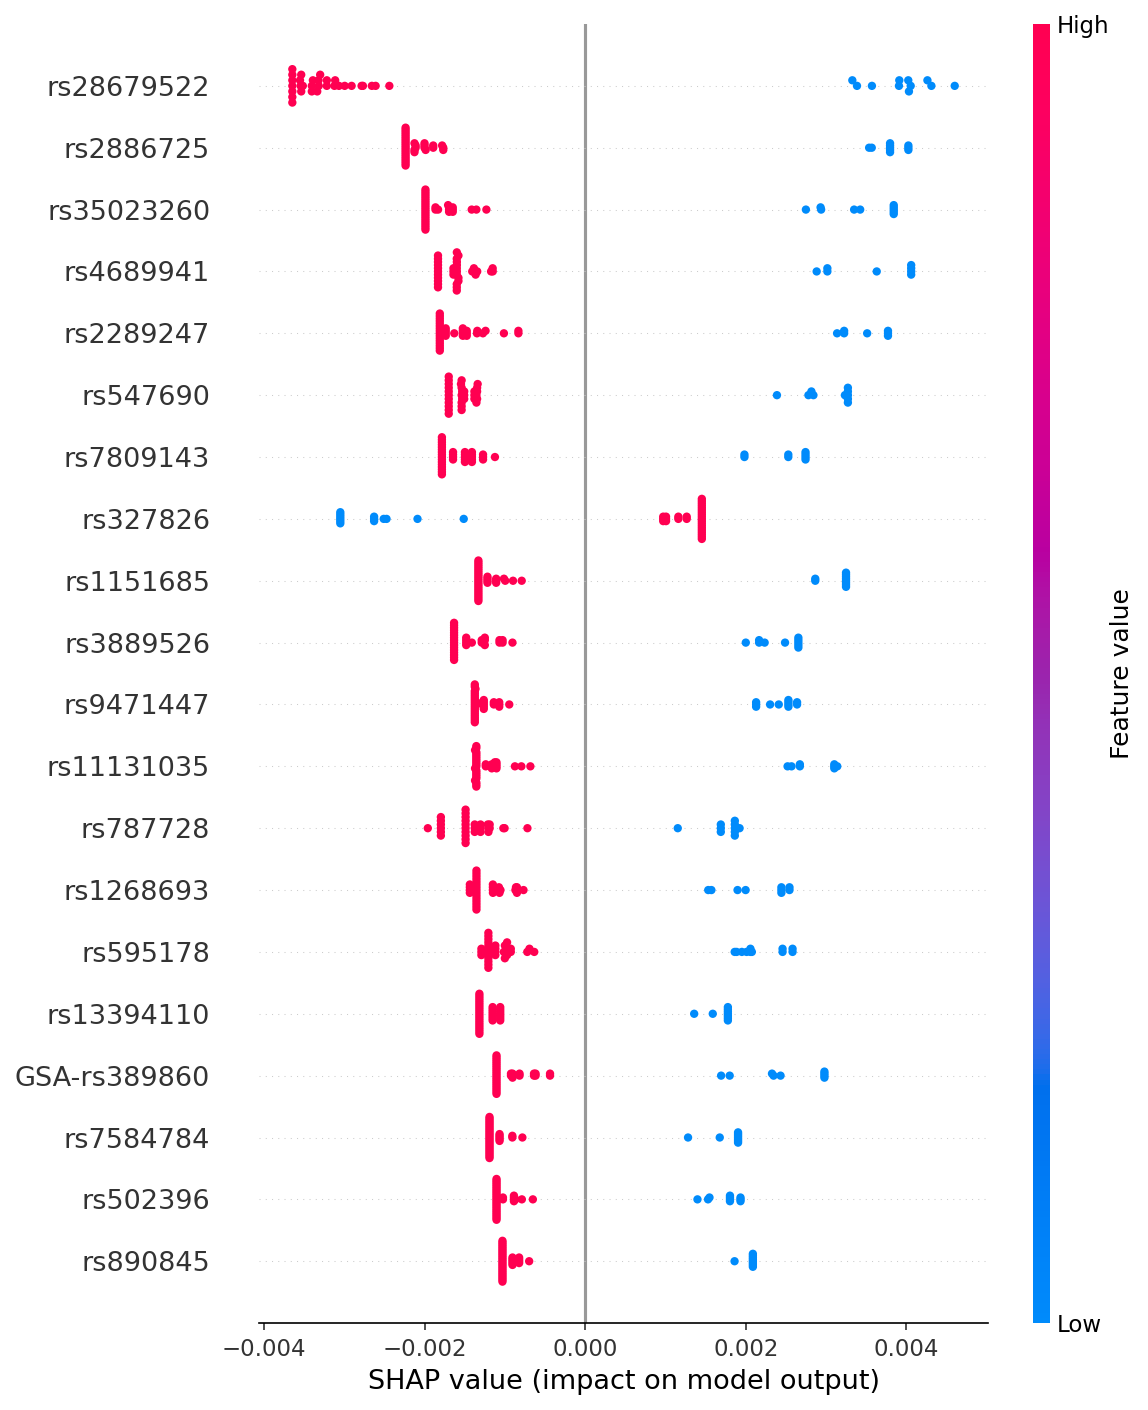


Clase 1 (etiqueta=1) — SHAP exacto (raw) con codificación DOMINANTE


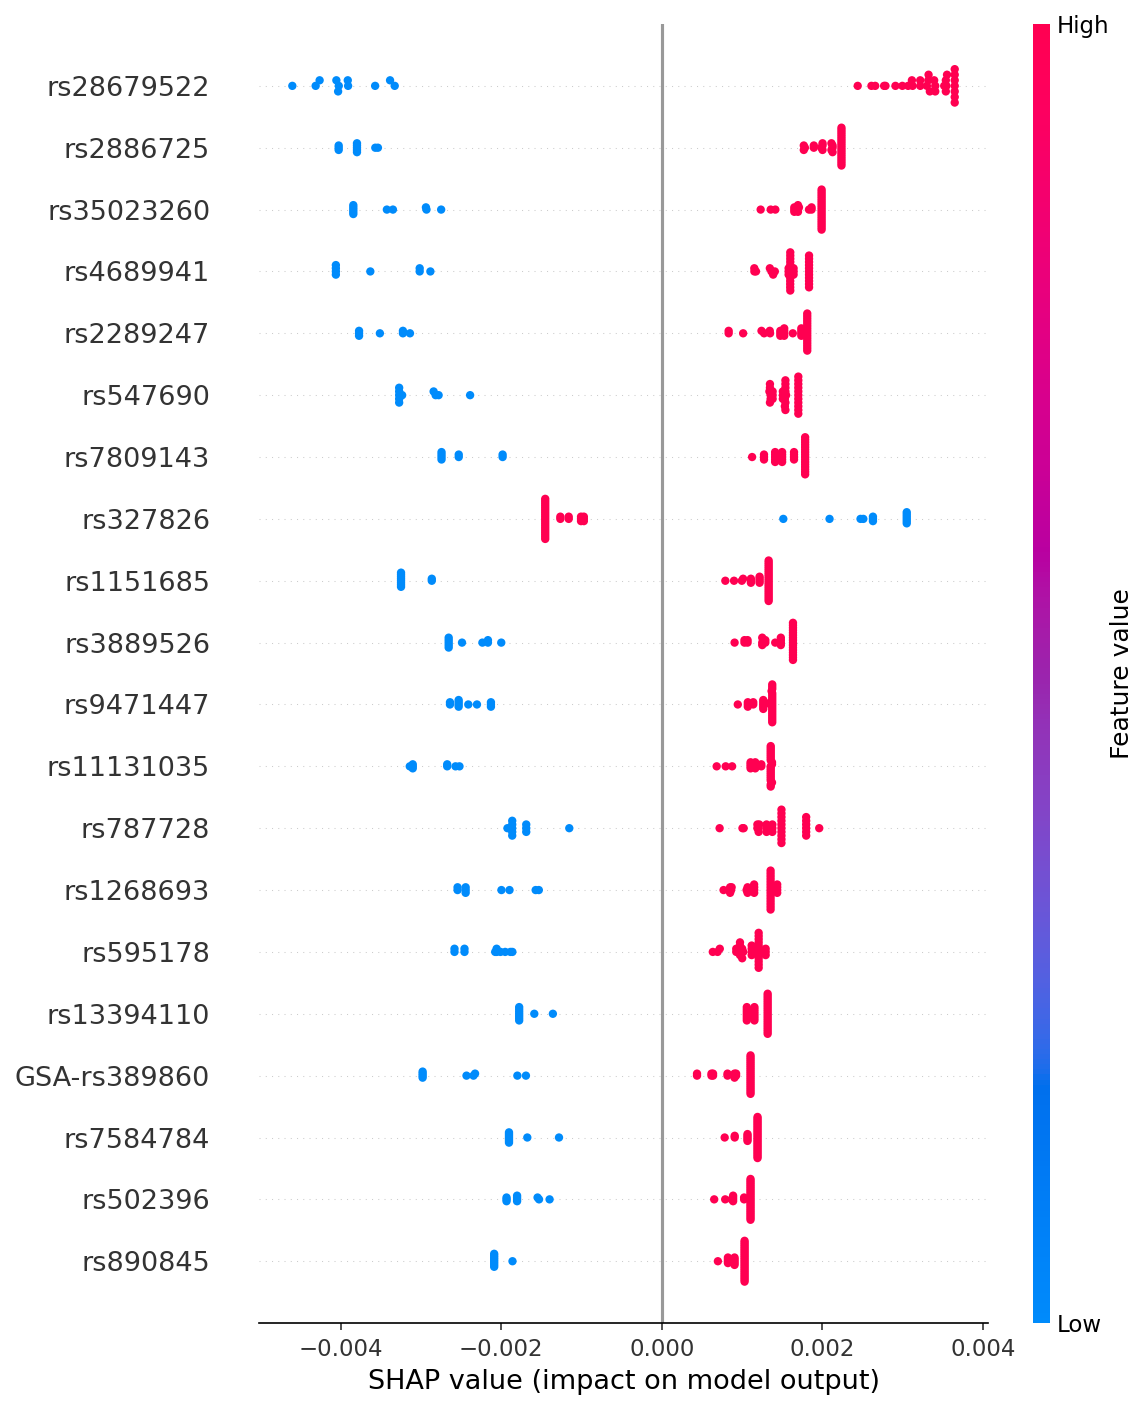


=== Top-30 SNPs por mean(|SHAP|) — RF + SHAP EXACTO (raw, DOMINANTE) ===
           SNP  mean_abs_SHAP_raw
    rs28679522           0.003453
     rs2886725           0.002527
    rs35023260           0.002232
     rs4689941           0.001991
     rs2289247           0.001914
      rs547690           0.001898
     rs7809143           0.001777
      rs327826           0.001742
     rs1151685           0.001704
     rs3889526           0.001679
     rs9471447           0.001588
    rs11131035           0.001555
      rs787728           0.001506
     rs1268693           0.001415
      rs595178           0.001372
    rs13394110           0.001331
  GSA-rs389860           0.001291
     rs7584784           0.001286
      rs502396           0.001210
      rs890845           0.001209
    rs13246232           0.001199
     rs1943392           0.001199
       rs26661           0.001177
GSA-rs12637929           0.001160
     rs7666030           0.001157
 GSA-rs1432314           0.001153
      rs

In [22]:
# ============================================================
# RandomForest + SHAP EXACTO (raw/log-odds) con codificación DOMINANTE (0/1)
# Faltantes: NaN -> -1 (categoría explícita)
# ============================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import shap

# 1) Datos alineados
X_df = G_reduced                      # {0,1,2,NaN}
y    = df_reduced['kmeans2'].values   # tus clases

# 2) Transformar a DOMINANTE (carrier): 0 si 0/0; 1 si 0/1 ó 1/1; NaN se mantiene
X_dom_df = X_df.where(X_df.isna(), (X_df >= 1).astype('float'))  # 0/1 + NaN
#     (OJO) Esto asume que el "alelo de efecto" es el que estás contando en 0/1/2.
#           Si tu 0/1/2 cuenta A1 y quieres "carrier de A1", esto es correcto.

# 3) Codificar faltantes como categoría explícita (-1)
X_rf_df = X_dom_df.fillna(-1.0)       # -1, 0, 1
feature_names = X_rf_df.columns.to_list()
X_rf = X_rf_df.values

# 4) Entrenar RF (tus hiperparámetros)
rf = RandomForestClassifier(
    n_estimators=600,
    criterion="log_loss",
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features=0.05,
    bootstrap=True,
    max_samples=0.7,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_rf, y)

# 5) SHAP EXACTO en espacio "raw" (log-odds)
explainer = shap.TreeExplainer(
    rf,
    model_output="raw",
    feature_perturbation="tree_path_dependent"
)
shap_out = explainer.shap_values(X_rf)

# 6) Normalizar forma a (n_samples, n_features, n_clases)
if isinstance(shap_out, list):
    shap_values = np.stack(shap_out, axis=2)
elif isinstance(shap_out, np.ndarray) and shap_out.ndim == 2:
    shap_values = shap_out[:, :, None]
else:
    shap_values = shap_out

classes = rf.classes_
n_classes = shap_values.shape[2]

# 7) Summary plots por clase (el color ahora refleja -1/0/1: missing/no-portador/portador)
for i, cls in enumerate(classes):
    print(f"\nClase {i} (etiqueta={cls}) — SHAP exacto (raw) con codificación DOMINANTE")
    shap.summary_plot(shap_values[:, :, i], X_rf, feature_names=feature_names, show=True)

# 8) Top-30 por mean(|SHAP|) en una clase
CLASS_TO_VIEW = 1 if n_classes > 1 else 0
mean_abs = np.abs(shap_values[:, :, CLASS_TO_VIEW]).mean(axis=0)
top_idx = np.argsort(mean_abs)[-30:][::-1]
top_snps = [feature_names[j] for j in top_idx]

top_table = pd.DataFrame({"SNP": top_snps, "mean_abs_SHAP_raw": mean_abs[top_idx]})
print("\n=== Top-30 SNPs por mean(|SHAP|) — RF + SHAP EXACTO (raw, DOMINANTE) ===")
print(top_table.to_string(index=False))


In [23]:
# 4) Split 80/20 estratificado (semilla=10)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_rf, y, test_size=0.20, random_state=10, stratify=y
)

# 5) Entrenar RF SOLO en train
rf = RandomForestClassifier(
    n_estimators=600,
    criterion="log_loss",
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features=0.05,
    bootstrap=True,
    max_samples=0.7,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_tr, y_tr)

# 6) Evaluación en test (ROC/PR + Youden) con corrección de dirección si hace falta
proba_te = rf.predict_proba(X_te)[:, 1]
auc_dir  = roc_auc_score(y_te, proba_te)
auc_inv  = roc_auc_score(y_te, 1 - proba_te)
use_inv  = auc_inv > auc_dir
proba_eval = (1 - proba_te) if use_inv else proba_te
auc_roc = max(auc_dir, auc_inv)

fpr, tpr, thr_roc = roc_curve(y_te, proba_eval)
prec, rec, thr_pr = precision_recall_curve(y_te, proba_eval)
ap = average_precision_score(y_te, proba_eval)

youden_idx = (tpr - fpr).argmax()
thr_opt = thr_roc[youden_idx]
y_pred = (proba_eval >= thr_opt).astype(int)

print(f"[TEST] AUC-ROC = {auc_roc:.3f} | AUPRC = {ap:.3f} | invertido={use_inv}")
print(f"[TEST] Umbral óptimo (Youden J) = {thr_opt:.4f}")
print("[TEST] Matriz de confusión:\n", confusion_matrix(y_te, y_pred))
print("[TEST] Classification report:\n", classification_report(y_te, y_pred, digits=3))




[TEST] AUC-ROC = 0.750 | AUPRC = 0.835 | invertido=True
[TEST] Umbral óptimo (Youden J) = 0.3835
[TEST] Matriz de confusión:
 [[3 1]
 [1 4]]
[TEST] Classification report:
               precision    recall  f1-score   support

           0      0.750     0.750     0.750         4
           1      0.800     0.800     0.800         5

    accuracy                          0.778         9
   macro avg      0.775     0.775     0.775         9
weighted avg      0.778     0.778     0.778         9



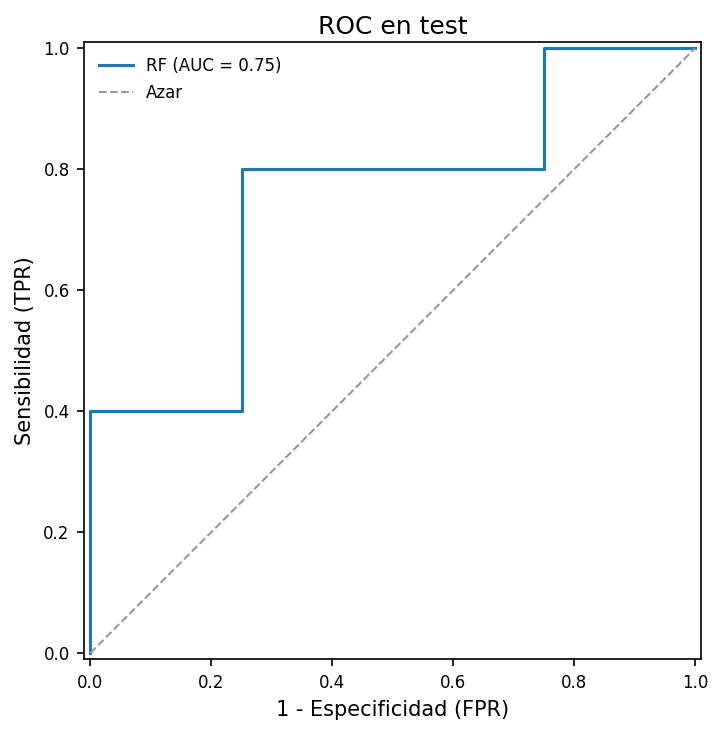

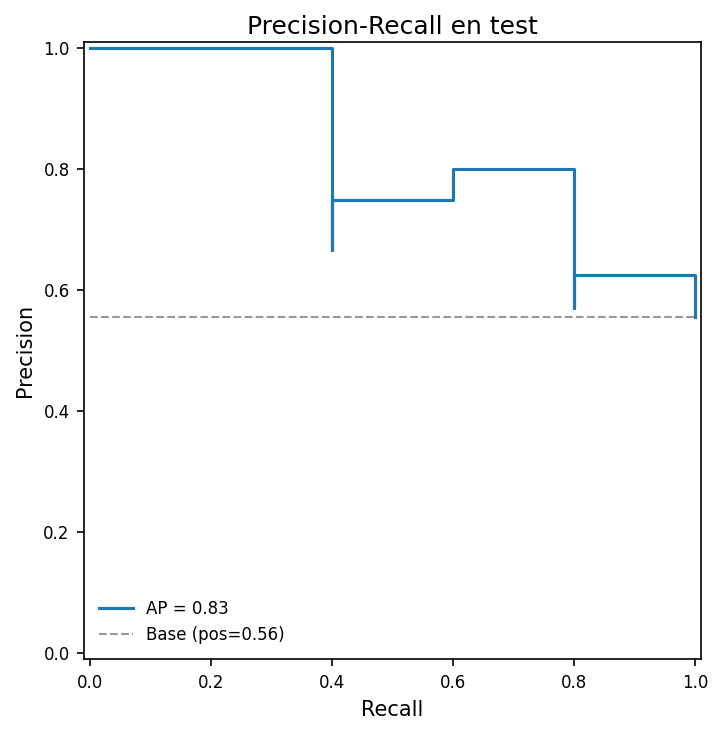

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# --- Curva ROC ---
plt.figure(figsize=(6,5), dpi=150)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc, estimator_name="RF").plot(ax=plt.gca())
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, color="0.6", label="Azar")
plt.title("ROC en test")
plt.xlabel("1 - Especificidad (FPR)")
plt.ylabel("Sensibilidad (TPR)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- Curva Precision-Recall ---
plt.figure(figsize=(6,5), dpi=150)
PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=ap).plot(ax=plt.gca())
# línea base = prevalencia positiva en test
base = (y_te == 1).mean()
plt.hlines(base, 0, 1, colors="0.6", linestyles="--", linewidth=1, label=f"Base (pos={base:.2f})")
plt.title("Precision-Recall en test")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(frameon=False, loc="lower left")
plt.tight_layout()
plt.show()


AUC-ROC (CV): 0.678 ± 0.129
AUPRC   (CV): 0.814 ± 0.081


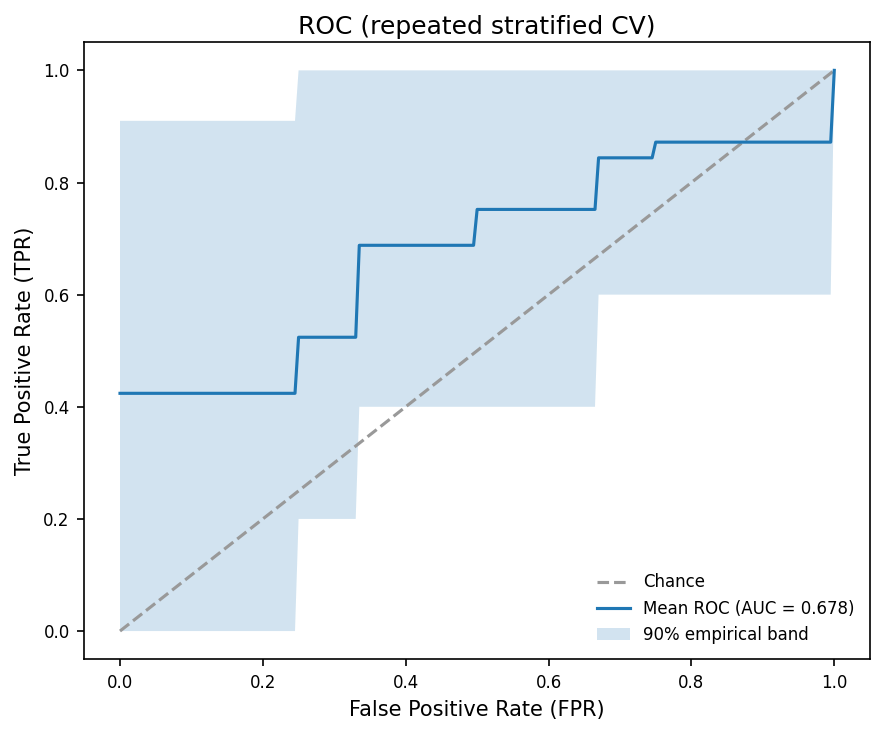

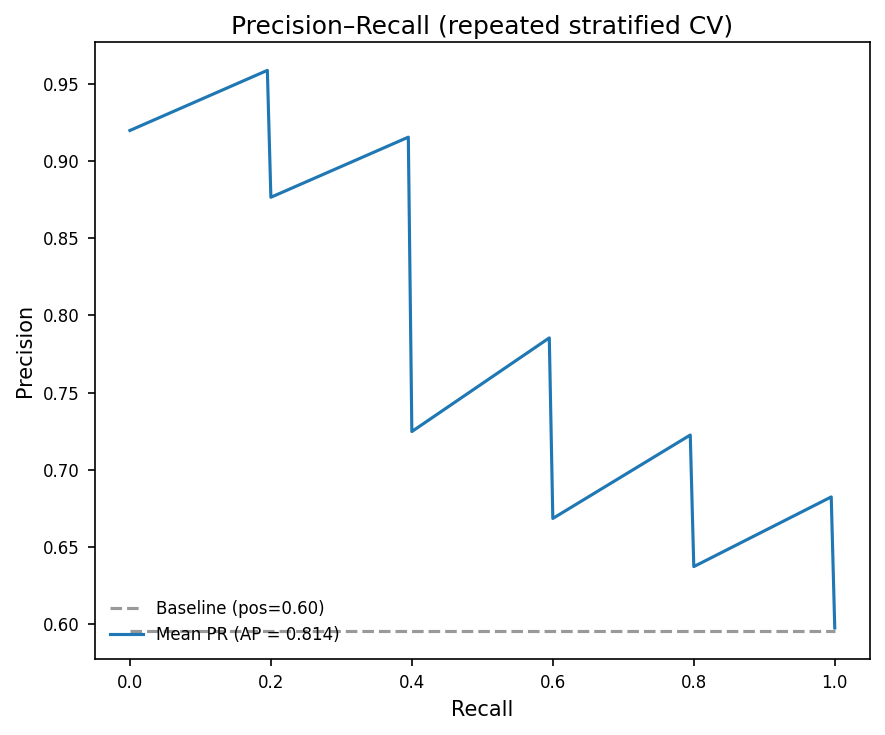

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier

X = X_rf
y = y.astype(int)

# Same RF you use
def make_rf():
    return RandomForestClassifier(
        n_estimators=600, criterion="log_loss",
        max_depth=6, min_samples_split=6, min_samples_leaf=3,
        max_features=0.05, bootstrap=True, max_samples=0.7,
        class_weight="balanced", n_jobs=-1, random_state=42
    )

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=10)

aucs, aps = [], []
fpr_grid = np.linspace(0, 1, 201)
mean_tprs = []
rec_grid = np.linspace(0, 1, 201)
prec_lists = []

for tr_idx, te_idx in cv.split(X, y):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    rf = make_rf()
    rf.fit(X_tr, y_tr)
    proba = rf.predict_proba(X_te)[:, 1]

    # Fix score direction if needed (same logic as your code)
    auc_dir = roc_auc_score(y_te, proba)
    auc_inv = roc_auc_score(y_te, 1 - proba)
    proba_eval = (1 - proba) if auc_inv > auc_dir else proba

    aucs.append(roc_auc_score(y_te, proba_eval))
    aps.append(average_precision_score(y_te, proba_eval))

    fpr, tpr, _ = roc_curve(y_te, proba_eval)
    mean_tprs.append(np.interp(fpr_grid, fpr, tpr))

    prec, rec, _ = precision_recall_curve(y_te, proba_eval)
    # Interpolate precision on a monotonically increasing recall grid
    # (left-fill with the first value)
    prec_interp = np.interp(rec_grid, rec[::-1], prec[::-1])
    prec_lists.append(prec_interp)

print(f"AUC-ROC (CV): {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
print(f"AUPRC   (CV): {np.mean(aps):.3f} ± {np.std(aps):.3f}")

# --- Mean ROC curve ---
plt.figure(figsize=(6,5), dpi=150)
plt.plot([0,1], [0,1], '--', color='0.6', label='Chance')
plt.plot(fpr_grid, np.mean(mean_tprs, axis=0), label=f"Mean ROC (AUC = {np.mean(aucs):.3f})")
plt.fill_between(
    fpr_grid,
    np.percentile(mean_tprs, 5, axis=0),
    np.percentile(mean_tprs, 95, axis=0),
    alpha=0.2, label="90% empirical band"
)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC (repeated stratified CV)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- Mean Precision-Recall curve ---
base = (y == 1).mean()
plt.figure(figsize=(6,5), dpi=150)
plt.hlines(base, 0, 1, linestyles="--", colors="0.6", label=f"Baseline (pos={base:.2f})")
prec_mean = np.mean(prec_lists, axis=0)
plt.plot(rec_grid, prec_mean, label=f"Mean PR (AP = {np.mean(aps):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (repeated stratified CV)")
plt.legend(frameon=False, loc="lower left")
plt.tight_layout()
plt.show()


In [31]:
# ============================================
# Top-K por SHAP (clase 0) + orden por pseudotiempo + heatmaps 0/1 y SHAP
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import matplotlib as mpl

# ---------- PARÁMETROS ----------
CLASS_TARGET = 0         # Clase para la que medimos SHAP
TOP_K = 10               # Número de SNPs a mostrar
PT_VECTOR = None         # np.ndarray shape (n,) si lo tienes fuera (opcional)
PT_COL = "pseudotime"    # o nombre de columna en X_base con el pseudotiempo (opcional)
SEED = 42

# ---------- INSUMOS QUE DEBES TENER ----------
# shap_values: puede ser lista [neg,pos] o array (n_samples, n_features[, n_classes])
# feature_names: lista con nombres (longitud = n_features)
# X_dom_df: DataFrame (n_samples x n_features) con 0/1/NaN (dominante)
# X_base: DataFrame (n_samples x p) cuyo índice coincide con X_dom_df (para tomar PT si viene en columna)

# ---------- 1) Normalizar salida SHAP y tomar CLASE 0 ----------
if isinstance(shap_values, list):
    # Caso binario: típicamente [clase0, clase1]
    if len(shap_values) <= CLASS_TARGET:
        raise ValueError(f"CLASS_TARGET={CLASS_TARGET} fuera de rango para shap_values (len={len(shap_values)})")
    shap_cls = shap_values[CLASS_TARGET]    # (n_samples, n_features)
else:
    arr = np.asarray(shap_values)
    if arr.ndim == 2:
        shap_cls = arr                       # (n_samples, n_features) sin eje de clase
    elif arr.ndim == 3:
        shap_cls = arr[:, :, CLASS_TARGET]   # (n_samples, n_features) con eje de clase
    else:
        raise ValueError("Forma de shap_values no soportada.")

# Sanidad básica
if shap_cls.shape[1] != len(feature_names):
    raise ValueError("feature_names no coincide con el número de columnas en shap_cls.")

# ---------- 2) Ranking Top-K por mean(|SHAP|) de la CLASE 0 ----------
mean_abs_shap = np.mean(np.abs(shap_cls), axis=0)            # (n_features,)
order = np.argsort(mean_abs_shap)[::-1]
top_idx = order[:TOP_K]
top_snps = [feature_names[i] for i in top_idx]
print("Top SNPs por mean(|SHAP|) en clase 0:\n", top_snps)

# ---------- 3) Orden por pseudotiempo ----------
n = X_dom_df.shape[0]
if PT_VECTOR is not None:
    pt = np.asarray(PT_VECTOR, dtype=float)
    if pt.shape[0] != n:
        raise ValueError(f"PT_VECTOR debe tener longitud {n}, tiene {pt.shape[0]}")
elif PT_COL is not None:
    if PT_COL not in X_base.columns:
        raise ValueError(f"La columna de pseudotiempo '{PT_COL}' no existe en X_base.")
    pt = X_base[PT_COL].to_numpy(dtype=float)
else:
    raise ValueError("Debes proveer PT_VECTOR o PT_COL.")

# manejar NaN en pseudotiempo: mandar al final
pt_fill = np.where(np.isfinite(pt), pt, np.nanmax(pt[np.isfinite(pt)]) + 1.0)
pt_sorted_idx = np.argsort(pt_fill)

# ---------- 4) Construir matrices alineadas (muestras por pseudotiempo) ----------
# 4a) Genotipo dominante 0/1 (-1 = missing)
M_bin = X_dom_df.loc[:, top_snps].iloc[pt_sorted_idx].copy()
M_vis = M_bin.fillna(-1).astype(float)  # -1,0,1

# 4b) SHAP para esos mismos SNPs y orden de muestras
#     Necesitamos la misma selección de columnas y el mismo orden de filas
shap_top = shap_cls[:, top_idx]                    # (n_samples, TOP_K)
shap_top_sorted = shap_top[pt_sorted_idx, :]      # (n_samples_sorted, TOP_K)

# ---------- 5) HEATMAP 0/1 (con -1 en gris) ----------
cmap3 = ListedColormap(["#d0d0d0", "#377eb8", "#e41a1c"])   # -1, 0, 1
norm3 = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap3.N)

fig1, ax1 = plt.subplots(figsize=(max(8, M_vis.shape[0]/28), 2 + 0.4*len(top_snps)))
im1 = ax1.imshow(M_vis.values.T, aspect="auto", cmap=cmap3, norm=norm3)
ax1.set_yticks(np.arange(len(top_snps)))
ax1.set_yticklabels(top_snps)
ax1.set_xticks([])  # demasiadas muestras; opcional: etiquetas dispersas
ax1.set_xlabel("Muestras ordenadas por pseudotiempo")
ax1.set_title(f"Top-{TOP_K} SNPs (dominante 0/1; gris = missing) — orden por pseudotiempo")

legend_elems = [
    Patch(facecolor="#d0d0d0", label="missing"),
    Patch(facecolor="#377eb8", label="0 (no portador)"),
    Patch(facecolor="#e41a1c", label="1 (portador)")
]
ax1.legend(handles=legend_elems, loc="upper left", bbox_to_anchor=(1.02, 1.0),
           frameon=False, title="Estado")
plt.tight_layout()
plt.show()

# ---------- 6) HEATMAP SHAP (continuo) para los mismos SNPs ----------
# Escalado robusto para color (p2–p98) centrado en 0
lo, hi = np.percentile(shap_top_sorted[np.isfinite(shap_top_sorted)], [2, 98])
# asegurar que incluimos 0 en el rango
m = max(abs(lo), abs(hi))
norm_div = mpl.colors.TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

fig2, ax2 = plt.subplots(figsize=(max(8, shap_top_sorted.shape[0]/28), 2 + 0.4*len(top_snps)))
im2 = ax2.imshow(shap_top_sorted.T, aspect="auto", cmap="RdBu_r", norm=norm_div)
ax2.set_yticks(np.arange(len(top_snps)))
ax2.set_yticklabels(top_snps)
ax2.set_xticks([])
ax2.set_xlabel("Muestras ordenadas por pseudotiempo")
ax2.set_title(f"SHAP (clase {CLASS_TARGET}) para Top-{TOP_K} SNPs — orden por pseudotiempo")

cbar = plt.colorbar(im2, ax=ax2, shrink=0.9)
cbar.set_label("SHAP (log-odds, centrado en 0)")
plt.tight_layout()
plt.show()

# ---------- 7) (Opcional) devolver / guardar matrices ----------
top_matrix_binary = M_vis                 # DataFrame [-1,0,1] (n_muestras_sorted x TOP_K)
top_matrix_shap   = pd.DataFrame(         # SHAP (n_muestras_sorted x TOP_K)
    shap_top_sorted, index=M_vis.index, columns=top_snps
)
# top_matrix_binary.to_csv("top_snps_binary_by_pseudotime.csv")
# top_matrix_shap.to_csv("top_snps_shap_by_pseudotime.csv")
# ================================
# Minimalist aligned heatmaps (EN)
# ================================
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- inputs expected: pt_sorted_idx, res['pseudo_time'], M_vis (-1/0/1), shap_top_sorted (float), top_snps
# If not present, rebuild from 'res', 'X_dom_df', 'shap_values', 'feature_names' (same as before).

mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 9
})

# Pseudotime (0–1)
pt = res["pseudo_time"].astype(float)
pt_sorted_idx = res["pt_sorted_idx"]
pt_norm = (pt - np.nanmin(pt)) / (np.nanmax(pt) - np.nanmin(pt) + 1e-12)
pt_norm_sorted = pt_norm[pt_sorted_idx]

# Colors & norms
cmap_bin = ListedColormap(["#cfcfcf", "#2b83ba", "#d7191c"])   # missing, 0, 1
norm_bin = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap_bin.N)

finite_vals = shap_top_sorted[np.isfinite(shap_top_sorted)]
lo, hi = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (-1, 1)
m = float(max(abs(lo), abs(hi))) if np.isfinite([lo, hi]).all() else 1.0
norm_div = mpl.colors.TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

# Figure
n_samples = M_vis.shape[0]
K = len(top_snps)
fig_w = 5
fig_h = 4
fig = plt.figure(figsize=(fig_w, fig_h))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=1,
                           height_ratios=[0.45, K*0.42, K*0.42],
                           hspace=0.08)

# 1) Pseudotime stripe (no title)
ax_pt = fig.add_subplot(gs[0, 0])
ax_pt.imshow(pt_norm_sorted[np.newaxis, :], aspect="auto", cmap="viridis", vmin=0, vmax=1)
ax_pt.set_yticks([]); ax_pt.set_xticks([])
for spine in ax_pt.spines.values(): spine.set_visible(False)

# 2) Binary genotype heatmap (−1/0/1)
ax_bin = fig.add_subplot(gs[1, 0])
im_bin = ax_bin.imshow(M_vis.values.T, aspect="auto", cmap=cmap_bin, norm=norm_bin, interpolation="nearest")
ax_bin.set_yticks(np.arange(K)); ax_bin.set_yticklabels(top_snps)
ax_bin.set_xticks([])
ax_bin.set_xlabel("")  # no title, no x-label
# minimal spines
for s in ["top","right"]: ax_bin.spines[s].set_visible(False)

# 3) SHAP heatmap
ax_shap = fig.add_subplot(gs[2, 0])
im_shap = ax_shap.imshow(shap_top_sorted.T, aspect="auto", cmap="RdBu_r", norm=norm_div, interpolation="nearest")
ax_shap.set_yticks(np.arange(K)); ax_shap.set_yticklabels(top_snps)
ax_shap.set_xticks(np.arange(0, n_samples, max(1, n_samples//8)))
ax_shap.set_xticklabels([])  # keep axis but hide text for minimal look
ax_shap.set_xlabel("")       # no label
for s in ["top","right"]: ax_shap.spines[s].set_visible(False)

# Slim colorbars (no frames, short labels)
cax1 = fig.add_axes([0.93, 0.56, 0.012, 0.28])
cb1 = plt.colorbar(im_bin, cax=cax1); cb1.outline.set_visible(False)
cb1.set_ticks([-1, 0, 1]); cb1.set_ticklabels(["miss", "0", "1"])

cax2 = fig.add_axes([0.93, 0.18, 0.012, 0.28])
cb2 = plt.colorbar(im_shap, cax=cax2); cb2.outline.set_visible(False)
cb2.set_label("SHAP", fontsize=9)

fig.subplots_adjust(left=0.17, right=0.91, top=0.98, bottom=0.06)
plt.show()


Top SNPs por mean(|SHAP|) en clase 0:
 ['rs28679522', 'rs2886725', 'rs35023260', 'rs4689941', 'rs2289247', 'rs547690', 'rs7809143', 'rs327826', 'rs1151685', 'rs3889526']


NameError: name 'X_base' is not defined

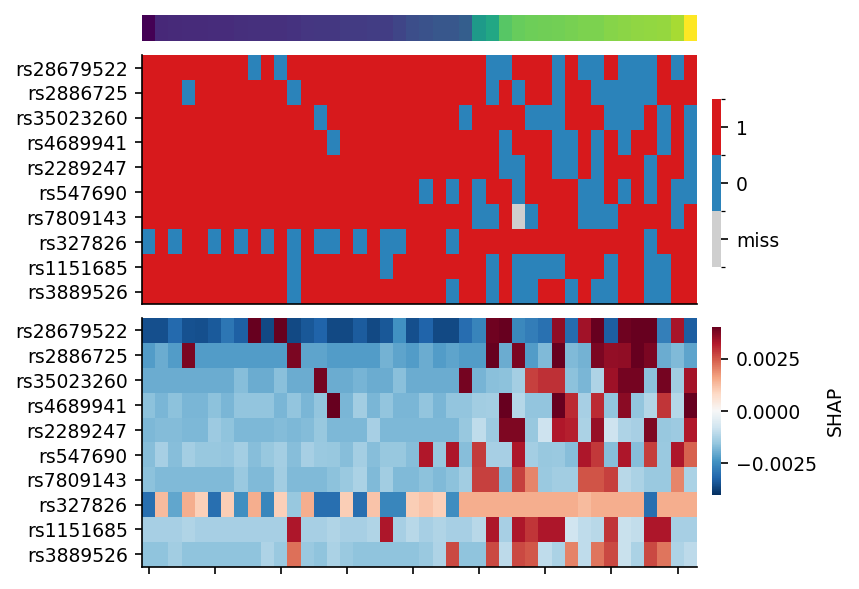

In [41]:
# ================================
# Minimalist aligned heatmaps (EN)
# ================================
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- inputs expected: pt_sorted_idx, res['pseudo_time'], M_vis (-1/0/1), shap_top_sorted (float), top_snps
# If not present, rebuild from 'res', 'X_dom_df', 'shap_values', 'feature_names' (same as before).

mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 9
})

# Pseudotime (0–1)
pt = res["pseudo_time"].astype(float)
pt_sorted_idx = res["pt_sorted_idx"]
pt_norm = (pt - np.nanmin(pt)) / (np.nanmax(pt) - np.nanmin(pt) + 1e-12)
pt_norm_sorted = pt_norm[pt_sorted_idx]

# Colors & norms
cmap_bin = ListedColormap(["#cfcfcf", "#2b83ba", "#d7191c"])   # missing, 0, 1
norm_bin = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap_bin.N)

finite_vals = shap_top_sorted[np.isfinite(shap_top_sorted)]
lo, hi = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (-1, 1)
m = float(max(abs(lo), abs(hi))) if np.isfinite([lo, hi]).all() else 1.0
norm_div = mpl.colors.TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

# Figure
n_samples = M_vis.shape[0]
K = len(top_snps)
fig_w = 5
fig_h = 4
fig = plt.figure(figsize=(fig_w, fig_h))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=1,
                           height_ratios=[0.45, K*0.42, K*0.42],
                           hspace=0.08)

# 1) Pseudotime stripe (no title)
ax_pt = fig.add_subplot(gs[0, 0])
ax_pt.imshow(pt_norm_sorted[np.newaxis, :], aspect="auto", cmap="viridis", vmin=0, vmax=1)
ax_pt.set_yticks([]); ax_pt.set_xticks([])
for spine in ax_pt.spines.values(): spine.set_visible(False)

# 2) Binary genotype heatmap (−1/0/1)
ax_bin = fig.add_subplot(gs[1, 0])
im_bin = ax_bin.imshow(M_vis.values.T, aspect="auto", cmap=cmap_bin, norm=norm_bin, interpolation="nearest")
ax_bin.set_yticks(np.arange(K)); ax_bin.set_yticklabels(top_snps)
ax_bin.set_xticks([])
ax_bin.set_xlabel("")  # no title, no x-label
# minimal spines
for s in ["top","right"]: ax_bin.spines[s].set_visible(False)

# 3) SHAP heatmap
ax_shap = fig.add_subplot(gs[2, 0])
im_shap = ax_shap.imshow(shap_top_sorted.T, aspect="auto", cmap="RdBu_r", norm=norm_div, interpolation="nearest")
ax_shap.set_yticks(np.arange(K)); ax_shap.set_yticklabels(top_snps)
ax_shap.set_xticks(np.arange(0, n_samples, max(1, n_samples//8)))
ax_shap.set_xticklabels([])  # keep axis but hide text for minimal look
ax_shap.set_xlabel("")       # no label
for s in ["top","right"]: ax_shap.spines[s].set_visible(False)

# Slim colorbars (no frames, short labels)
cax1 = fig.add_axes([0.93, 0.56, 0.012, 0.28])
cb1 = plt.colorbar(im_bin, cax=cax1); cb1.outline.set_visible(False)
cb1.set_ticks([-1, 0, 1]); cb1.set_ticklabels(["miss", "0", "1"])

cax2 = fig.add_axes([0.93, 0.18, 0.012, 0.28])
cb2 = plt.colorbar(im_shap, cax=cax2); cb2.outline.set_visible(False)
cb2.set_label("SHAP", fontsize=9)

fig.subplots_adjust(left=0.17, right=0.91, top=0.98, bottom=0.06)
plt.show()


Top SNPs (mean|SHAP|, class 0): ['rs28679522', 'rs2886725', 'rs35023260', 'rs4689941', 'rs2289247', 'rs547690', 'rs7809143', 'rs327826', 'rs1151685', 'rs3889526', 'rs9471447', 'rs11131035', 'rs787728', 'rs1268693', 'rs595178', 'rs13394110', 'GSA-rs389860', 'rs7584784', 'rs502396', 'rs890845']


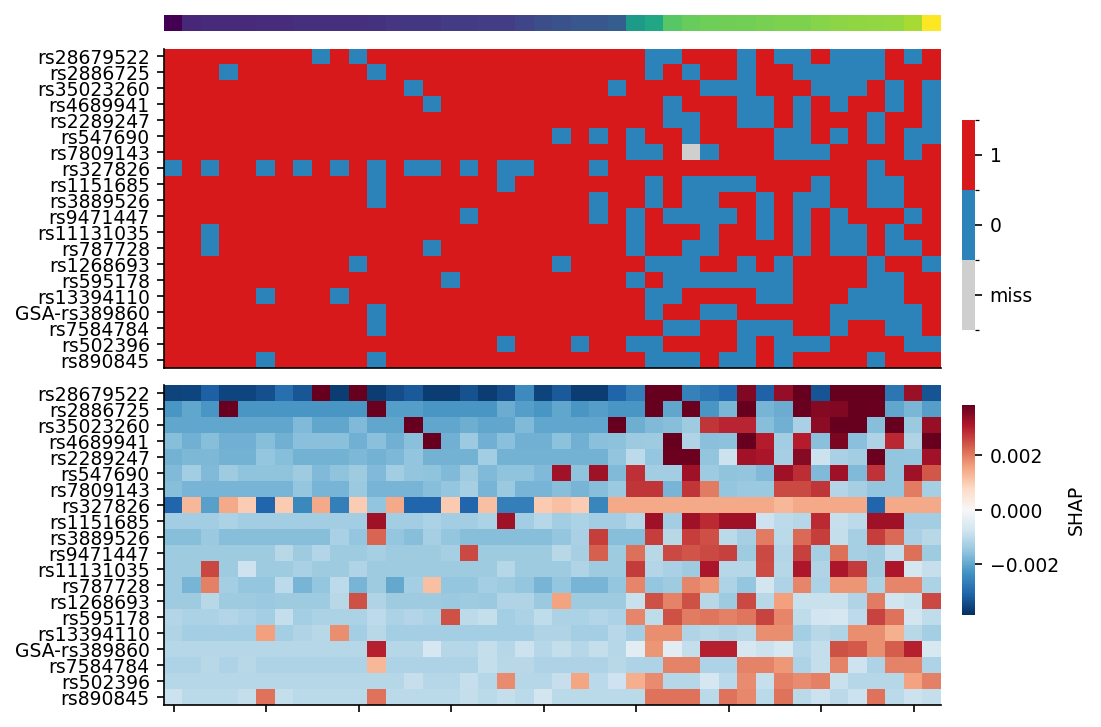

In [45]:
# ============================================
# Top-K SHAP (class 0) → order by pseudotime → minimal plots
# Needs: shap_values, feature_names, X_dom_df  (and res OR a PT source)
# ============================================
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ---------- PARAMS ----------
CLASS_TARGET   = 0        # SHAP for this class
TOP_K          = 20       # number of SNPs to show
PT_VECTOR      = None     # np.array (n,) optional
PT_COL         = None     # e.g. "pseudotime" in a DF you set as PT_DF
PT_DF          = None     # DataFrame containing PT_COL (aligned to X_dom_df)
USE_RES_FIRST  = True     # if 'res' exists, use its pseudotime/order first

# ---------- SANITY: required inputs ----------
# - shap_values: list or array (n, f[, c])
# - feature_names: list of length f
# - X_dom_df: DataFrame (n x f) with 0/1/NaN (dominant coding)

# ---------- 1) SHAP matrix for target class ----------
if isinstance(shap_values, list):
    if CLASS_TARGET >= len(shap_values):
        raise ValueError(f"CLASS_TARGET={CLASS_TARGET} out of range for shap_values (len={len(shap_values)})")
    shap_cls = np.asarray(shap_values[CLASS_TARGET])  # (n, f)
else:
    arr = np.asarray(shap_values)
    if arr.ndim == 2:
        shap_cls = arr                                # (n, f)
    elif arr.ndim == 3:
        shap_cls = arr[:, :, CLASS_TARGET]            # (n, f)
    else:
        raise ValueError("Unsupported shap_values shape")

if shap_cls.shape[1] != len(feature_names):
    raise ValueError("feature_names length must match SHAP n_features")

# ---------- 2) Pseudotime & ordering ----------
n = X_dom_df.shape[0]

pt_sorted_idx = None
pt = None

# 2a) from res (preferred)
if USE_RES_FIRST and 'res' in globals() and isinstance(res, dict):
    if 'pt_sorted_idx' in res and 'pseudo_time' in res:
        pt_sorted_idx = np.asarray(res['pt_sorted_idx'])
        pt = np.asarray(res['pseudo_time'], dtype=float)

# 2b) explicit vector
if (pt_sorted_idx is None) and (PT_VECTOR is not None):
    pt = np.asarray(PT_VECTOR, dtype=float)
    if pt.shape[0] != n:
        raise ValueError(f"PT_VECTOR length {pt.shape[0]} != {n}")
    pt_fill = np.where(np.isfinite(pt), pt, np.nanmax(pt[np.isfinite(pt)]) + 1.0)
    pt_sorted_idx = np.argsort(pt_fill)

# 2c) column in a DF
if (pt_sorted_idx is None) and (PT_COL is not None) and (PT_DF is not None):
    if not X_dom_df.index.equals(PT_DF.index):
        PT_DF = PT_DF.reindex(X_dom_df.index)  # align
    if PT_COL not in PT_DF.columns:
        raise ValueError(f"Column '{PT_COL}' not found in PT_DF")
    pt = PT_DF[PT_COL].to_numpy(dtype=float)
    pt_fill = np.where(np.isfinite(pt), pt, np.nanmax(pt[np.isfinite(pt)]) + 1.0)
    pt_sorted_idx = np.argsort(pt_fill)

if pt_sorted_idx is None:
    raise ValueError("No pseudotime source found. Provide res, PT_VECTOR, or PT_COL+PT_DF.")

# normalized pseudotime 0–1 for the stripe
pt_min, pt_max = np.nanmin(pt), np.nanmax(pt)
pt_norm_sorted = (pt - pt_min) / (pt_max - pt_min + 1e-12)
pt_norm_sorted = pt_norm_sorted[pt_sorted_idx]

# ---------- 3) Top-K SNPs by mean(|SHAP|) ----------
mean_abs = np.mean(np.abs(shap_cls), axis=0)           # (f,)
order = np.argsort(mean_abs)[::-1]
top_idx = order[:TOP_K]
top_snps = [feature_names[i] for i in top_idx]
print("Top SNPs (mean|SHAP|, class 0):", top_snps)

# ---------- 4) Build matrices with the same order ----------
# 4a) binary genotype (−1/0/1)
M_bin = X_dom_df.loc[:, top_snps].iloc[pt_sorted_idx].copy()
M_vis = M_bin.fillna(-1).astype(float)                 # (n_sorted x K)
# 4b) SHAP for the same SNPs & order
shap_top_sorted = shap_cls[:, top_idx][pt_sorted_idx, :]  # (n_sorted x K)

# ---------- 5) Minimal plots ----------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 9
})

K = len(top_snps)
n_sorted = M_vis.shape[0]
fig_w = 7
fig_h = 5

cmap_bin = ListedColormap(["#cfcfcf", "#2b83ba", "#d7191c"])  # missing, 0, 1
norm_bin = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap_bin.N)

finite_vals = shap_top_sorted[np.isfinite(shap_top_sorted)]
if finite_vals.size:
    lo, hi = np.percentile(finite_vals, [2, 98])
    m = float(max(abs(lo), abs(hi)))
else:
    m = 1.0
norm_div = mpl.colors.TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

fig = plt.figure(figsize=(fig_w, fig_h))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=1,
                           height_ratios=[0.45, K*0.44, K*0.44],
                           hspace=0.08)

# stripe: pseudotime
ax_pt = fig.add_subplot(gs[0, 0])
ax_pt.imshow(pt_norm_sorted[np.newaxis, :], aspect="auto", cmap="viridis", vmin=0, vmax=1)
ax_pt.set_yticks([]); ax_pt.set_xticks([])
for sp in ax_pt.spines.values(): sp.set_visible(False)

# heatmap: binary
ax_bin = fig.add_subplot(gs[1, 0])
im_bin = ax_bin.imshow(M_vis.values.T, aspect="auto", cmap=cmap_bin, norm=norm_bin, interpolation="nearest")
ax_bin.set_yticks(np.arange(K)); ax_bin.set_yticklabels(top_snps)
ax_bin.set_xticks([])  # keep clean
for s in ["top", "right"]: ax_bin.spines[s].set_visible(False)

# heatmap: SHAP
ax_shap = fig.add_subplot(gs[2, 0])
im_shap = ax_shap.imshow(shap_top_sorted.T, aspect="auto", cmap="RdBu_r", norm=norm_div, interpolation="nearest")
ax_shap.set_yticks(np.arange(K)); ax_shap.set_yticklabels(top_snps)
# sparse x ticks (indices)
tick_pos = np.arange(0, n_sorted, max(1, n_sorted // 8))
ax_shap.set_xticks(tick_pos); ax_shap.set_xticklabels([])  # minimalist
for s in ["top", "right"]: ax_shap.spines[s].set_visible(False)

# slim colorbars
cax1 = fig.add_axes([0.93, 0.56, 0.012, 0.28])
cb1 = plt.colorbar(im_bin, cax=cax1); cb1.outline.set_visible(False)
cb1.set_ticks([-1, 0, 1]); cb1.set_ticklabels(["miss", "0", "1"])

cax2 = fig.add_axes([0.93, 0.18, 0.012, 0.28])
cb2 = plt.colorbar(im_shap, cax=cax2); cb2.outline.set_visible(False)
cb2.set_label("SHAP", fontsize=9)

fig.subplots_adjust(left=0.17, right=0.91, top=0.98, bottom=0.06)
plt.show()

# ---------- 6) Return tables (optional) ----------
top_matrix_binary = M_vis.copy()  # (n_sorted x K) in [-1,0,1]
top_matrix_shap   = pd.DataFrame(shap_top_sorted, index=M_vis.index, columns=top_snps)
# top_matrix_binary.to_csv("top_snps_binary_by_pseudotime.csv")
# top_matrix_shap.to_csv("top_snps_shap_by_pseudotime.csv")


Showing 20 SNPs: ['rs28679522', 'rs2886725', 'rs35023260', 'rs4689941', 'rs2289247', 'rs547690', 'rs7809143', 'rs327826', 'rs1151685', 'rs3889526', 'rs9471447', 'rs11131035', 'rs787728', 'rs1268693', 'rs595178', 'rs13394110', 'GSA-rs389860', 'rs7584784', 'rs502396', 'rs890845']


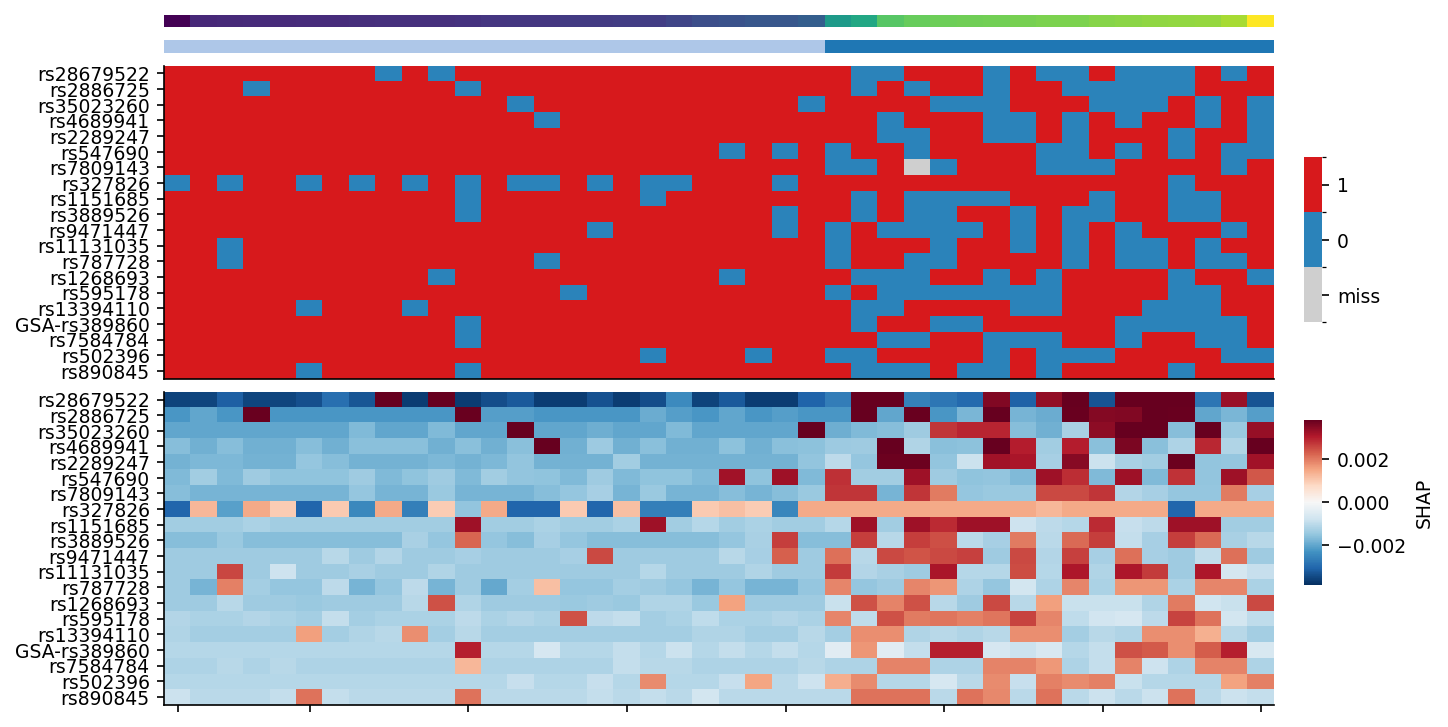

In [48]:
# ============================================================
# SHAP Top-K (class 0) → order by pseudotime → minimalist plots
# With pseudotime stripe + KMeans stripe + binary genotype + SHAP
# ============================================================
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# ------------- USER CONFIG -------------
CLASS_TARGET   = 0          # SHAP class to visualize
TOP_K          = 20         # number of SNPs (ignored if you set SNPS_TO_SHOW)
SNPS_TO_SHOW   = None       # e.g. ["rs1","rs2",...] to force a fixed list; else None → Top-K
USE_RES_FIRST  = True       # if a dict 'res' exists, use its pseudotime/order/labels
PT_VECTOR      = None       # np.array (n,) fallback pseudotime
PT_COL         = None       # e.g. "pseudotime" in PT_DF
PT_DF          = None       # DataFrame aligned to X_dom_df (index) for PT_COL

# Layout tweaks
XTICK_SLOTS    = 8          # how many sparse x-ticks to reserve (labels hidden for minimal look)
FIG_W_FACTOR   = 28.0       # figure width ~ n_samples / FIG_W_FACTOR
ROW_SCALE      = 0.44       # vertical scale per SNP row
# ---------------------------------------

# ========== Required inputs ==========
# shap_values: list or array (n, f[, c])
# feature_names: list length f
# X_dom_df: DataFrame (n x f) with 0/1/NaN (dominant coding)

# ---------- 1) SHAP → matrix for target class ----------
if isinstance(shap_values, list):
    if CLASS_TARGET >= len(shap_values):
        raise ValueError(f"CLASS_TARGET={CLASS_TARGET} out of range for shap_values")
    shap_cls = np.asarray(shap_values[CLASS_TARGET])  # (n, f)
else:
    arr = np.asarray(shap_values)
    if arr.ndim == 2:
        shap_cls = arr                                # (n, f)
    elif arr.ndim == 3:
        shap_cls = arr[:, :, CLASS_TARGET]            # (n, f)
    else:
        raise ValueError("Unsupported shap_values shape")

if shap_cls.shape[1] != len(feature_names):
    raise ValueError("feature_names length does not match SHAP n_features")

n, f = shap_cls.shape

# ---------- 2) Pseudotime and sample order ----------
pt = None
pt_sorted_idx = None

# Prefer 'res' if available
if USE_RES_FIRST and 'res' in globals() and isinstance(res, dict):
    if ('pseudo_time' in res) and ('pt_sorted_idx' in res):
        pt = np.asarray(res['pseudo_time'], dtype=float)
        pt_sorted_idx = np.asarray(res['pt_sorted_idx'])

# Fallbacks
if pt_sorted_idx is None and (PT_VECTOR is not None):
    pt = np.asarray(PT_VECTOR, dtype=float)
    if pt.shape[0] != n:
        raise ValueError(f"PT_VECTOR length {pt.shape[0]} != {n}")
    pt_fill = np.where(np.isfinite(pt), pt, np.nanmax(pt[np.isfinite(pt)]) + 1.0)
    pt_sorted_idx = np.argsort(pt_fill)

if pt_sorted_idx is None and (PT_COL is not None) and (PT_DF is not None):
    if not X_dom_df.index.equals(PT_DF.index):
        PT_DF = PT_DF.reindex(X_dom_df.index)  # align by index
    if PT_COL not in PT_DF.columns:
        raise ValueError(f"Column '{PT_COL}' not found in PT_DF")
    pt = PT_DF[PT_COL].to_numpy(dtype=float)
    pt_fill = np.where(np.isfinite(pt), pt, np.nanmax(pt[np.isfinite(pt)]) + 1.0)
    pt_sorted_idx = np.argsort(pt_fill)

if pt_sorted_idx is None:
    raise ValueError("No pseudotime source. Provide 'res', or PT_VECTOR, or PT_COL+PT_DF.")

# normalized pseudotime (0–1) in pseudo-time order
pt_min, pt_max = np.nanmin(pt), np.nanmax(pt)
pt_norm = (pt - pt_min) / (pt_max - pt_min + 1e-12)
pt_norm_sorted = pt_norm[pt_sorted_idx]

# ---------- 3) SNP selection ----------
if SNPS_TO_SHOW is not None:
    # Fixed list (only those present in data)
    snps = [s for s in SNPS_TO_SHOW if s in X_dom_df.columns and s in feature_names]
    if not snps:
        raise ValueError("None of the SNPS_TO_SHOW are present in X_dom_df/feature_names.")
    top_snps = snps
    # Map SNP names to feature indices for SHAP
    col_idx = [feature_names.index(s) for s in top_snps]
else:
    # Top-K by mean(|SHAP|)
    mean_abs = np.mean(np.abs(shap_cls), axis=0)
    order = np.argsort(mean_abs)[::-1][:TOP_K]
    col_idx = list(order)
    top_snps = [feature_names[i] for i in col_idx]

K = len(top_snps)
print(f"Showing {K} SNPs:", top_snps)

# ---------- 4) Build matrices (same order/columns) ----------
# Binary genotype (−1/0/1) in pseudo-time order
M_bin = X_dom_df.loc[:, top_snps].iloc[pt_sorted_idx].copy()
M_vis = M_bin.fillna(-1).astype(float)                 # (n_sorted x K) in [-1,0,1]

# SHAP for the same SNPs and order
shap_top_sorted = shap_cls[:, col_idx][pt_sorted_idx, :]  # (n_sorted x K)

# ---------- 5) (Optional) KMeans labels stripe ----------
km_sorted = None
if ('labels' in globals().get('res', {})):
    km_labels = np.asarray(res['labels'])
    if km_labels.shape[0] == n:
        km_sorted = km_labels[pt_sorted_idx]
    else:
        print("[warn] 'res[labels]' length mismatch; skipping KMeans stripe.")

# ---------- 6) Minimalist plotting ----------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 9
})

n_sorted = M_vis.shape[0]
fig_w = 10

# color maps
cmap_bin = ListedColormap(["#cfcfcf", "#2b83ba", "#d7191c"])   # missing, 0, 1
norm_bin = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap_bin.N)

finite_vals = shap_top_sorted[np.isfinite(shap_top_sorted)]
if finite_vals.size:
    lo, hi = np.percentile(finite_vals, [2, 98])
    m = float(max(abs(lo), abs(hi)))
else:
    m = 1.0
norm_div = mpl.colors.TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

# grid height ratios: PT stripe, KM stripe (if any), binary, SHAP
if km_sorted is None:
    height = [0.45, K*ROW_SCALE, K*ROW_SCALE]
    nrows = 3
else:
    height = [0.35, 0.35, K*ROW_SCALE, K*ROW_SCALE]
    nrows = 4

fig_h = 5
fig = plt.figure(figsize=(fig_w, fig_h))
gs = mpl.gridspec.GridSpec(nrows=nrows, ncols=1, height_ratios=height, hspace=0.08)

# 6.1 pseudotime stripe
ax_pt = fig.add_subplot(gs[0, 0])
ax_pt.imshow(pt_norm_sorted[np.newaxis, :], aspect="auto", cmap="viridis", vmin=0, vmax=1)
ax_pt.set_yticks([]); ax_pt.set_xticks([])
for sp in ax_pt.spines.values(): sp.set_visible(False)

row_off = 1

# 6.2 KMeans stripe (optional)
if km_sorted is not None:
    ax_km = fig.add_subplot(gs[1, 0])
    uniq = np.unique(km_sorted)
    base = plt.get_cmap("tab20").colors
    colors = (base * ((len(uniq)//len(base))+1))[:len(uniq)]
    lab2color = {k: colors[i] for i, k in enumerate(uniq)}
    km_row = np.array([lab2color[int(k)] for k in km_sorted])
    ax_km.imshow(km_row[np.newaxis, :, :], aspect="auto")
    ax_km.set_yticks([]); ax_km.set_xticks([])
    for sp in ax_km.spines.values(): sp.set_visible(False)
else:
    row_off = 0  # no KM stripe → binary goes to row 1

# 6.3 binary genotype
ax_bin = fig.add_subplot(gs[1+row_off, 0])
im_bin = ax_bin.imshow(M_vis.values.T, aspect="auto", cmap=cmap_bin, norm=norm_bin, interpolation="nearest")
ax_bin.set_yticks(np.arange(K)); ax_bin.set_yticklabels(top_snps)
ax_bin.set_xticks([])
for s in ["top", "right"]: ax_bin.spines[s].set_visible(False)

# 6.4 SHAP
ax_shap = fig.add_subplot(gs[2+row_off, 0])
im_shap = ax_shap.imshow(shap_top_sorted.T, aspect="auto", cmap="RdBu_r", norm=norm_div, interpolation="nearest")
ax_shap.set_yticks(np.arange(K)); ax_shap.set_yticklabels(top_snps)
tick_pos = np.linspace(0, n_sorted-1, num=min(XTICK_SLOTS, n_sorted), dtype=int)
ax_shap.set_xticks(tick_pos); ax_shap.set_xticklabels([])  # keep minimal
for s in ["top", "right"]: ax_shap.spines[s].set_visible(False)

# slim colorbars (right side)
if km_sorted is None:
    # positions tuned for 3-row layout
    cax1 = fig.add_axes([0.93, 0.52, 0.012, 0.26])
    cax2 = fig.add_axes([0.93, 0.17, 0.012, 0.26])
else:
    # positions tuned for 4-row layout
    cax1 = fig.add_axes([0.93, 0.57, 0.012, 0.22])
    cax2 = fig.add_axes([0.93, 0.22, 0.012, 0.22])

cb1 = plt.colorbar(im_bin, cax=cax1); cb1.outline.set_visible(False)
cb1.set_ticks([-1, 0, 1]); cb1.set_ticklabels(["miss", "0", "1"])

cb2 = plt.colorbar(im_shap, cax=cax2); cb2.outline.set_visible(False)
cb2.set_label("SHAP", fontsize=9)

fig.subplots_adjust(left=0.17, right=0.91, top=0.98, bottom=0.06)
plt.show()

# ---------- 7) Optional exports ----------
top_matrix_binary = M_vis.copy()  # (n_sorted x K) in [-1,0,1]
top_matrix_shap   = pd.DataFrame(shap_top_sorted, index=M_vis.index, columns=top_snps)
# top_matrix_binary.to_csv("top_snps_binary_by_pseudotime.csv")
# top_matrix_shap.to_csv("top_snps_shap_by_pseudotime.csv")


/tmp/ipython-input-1088930517.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,1])


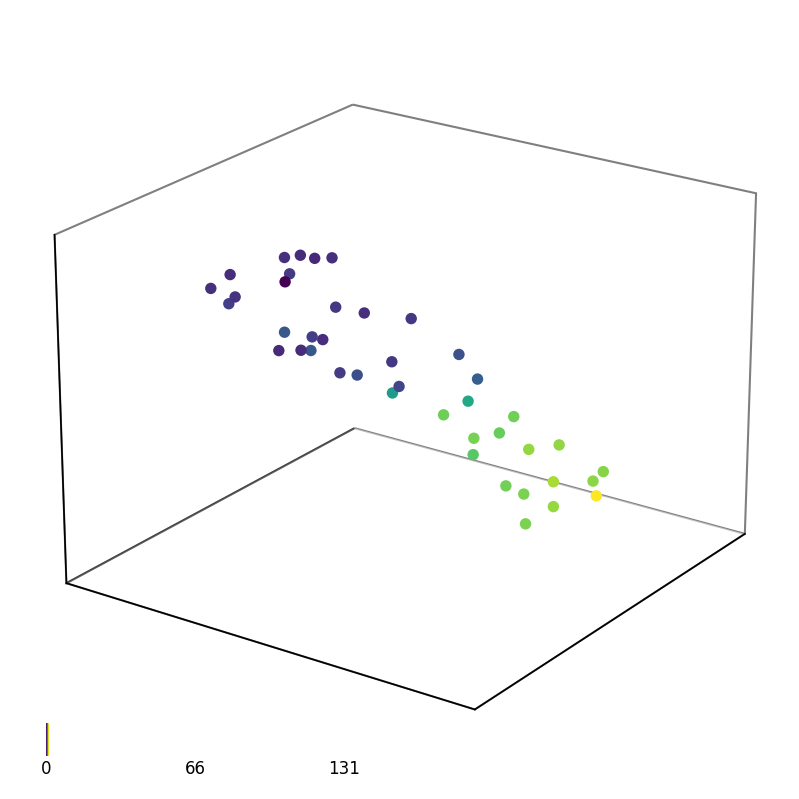

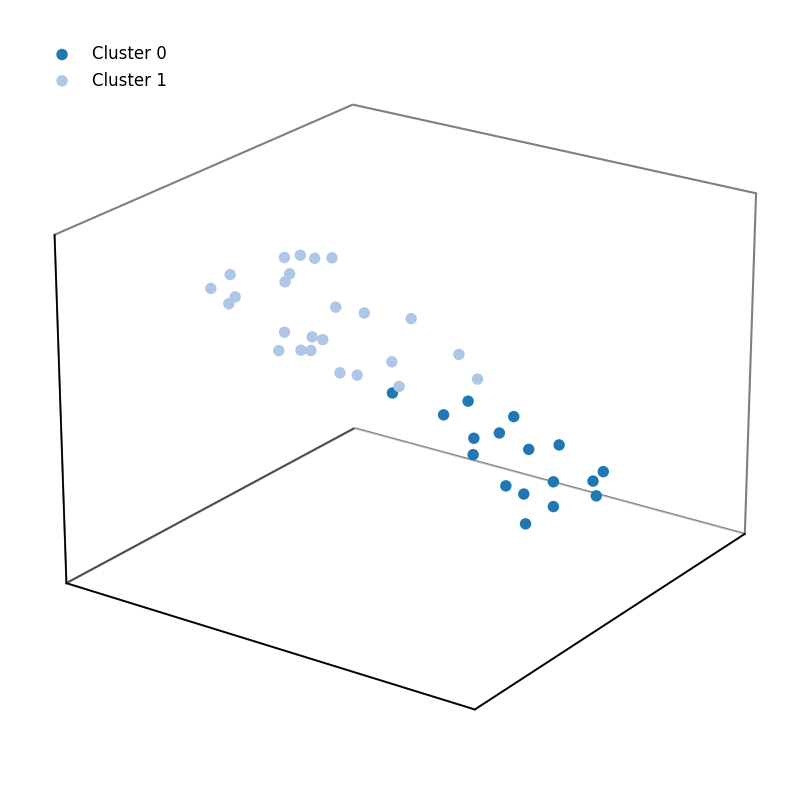

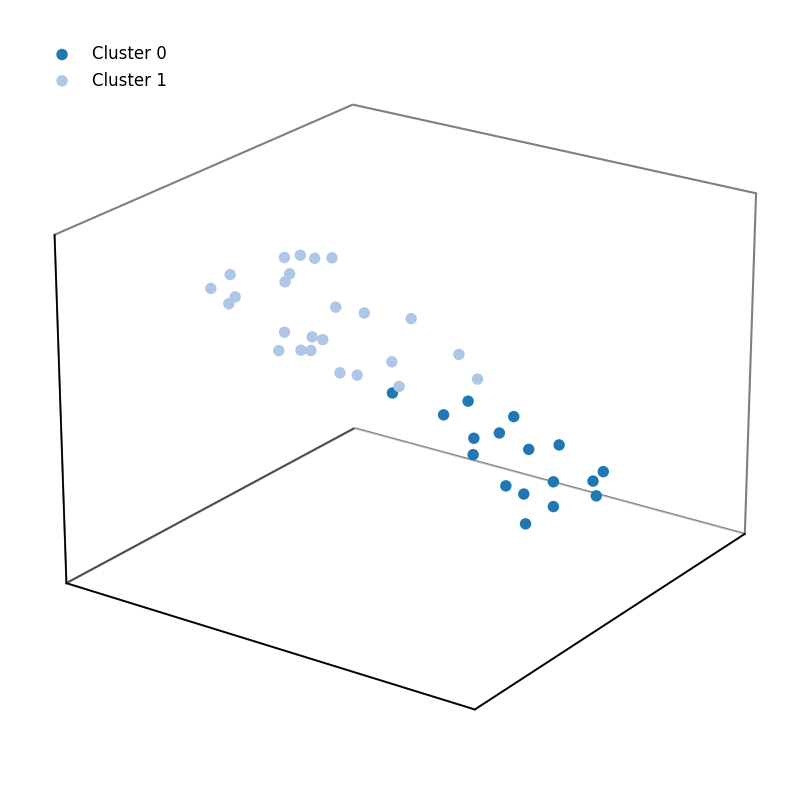

In [58]:
# =========================================================
# 3D UMAP — Minimal studio style (sin cubo, sin rejilla)
# Pseudotime (viridis + colorbar horizontal) & KMeans (leyenda)
# Orientación controlada (elev, azim) y límites isótropos
# =========================================================
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Ajuste global sobrio ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 9
})

# ---------- Utilidades geométricas ----------
def _equal_limits(X: np.ndarray):
    """Devuelve xlim, ylim, zlim para aspecto ~igual en 3D, sin dibujar cubo."""
    X = np.asarray(X, float)
    mn = X.min(axis=0); mx = X.max(axis=0)
    ctr = (mn + mx) / 2.0
    span = float(np.max(mx - mn))
    if not np.isfinite(span) or span <= 0:
        span = 1.0
    lo, hi = ctr - span/2, ctr + span/2
    return (lo[0], hi[0]), (lo[1], hi[1]), (lo[2], hi[2])

def _apply_limits_and_view(ax, X, elev=22, azim=35):
    (xmin, xmax), (ymin, ymax), (zmin, zmax) = _equal_limits(X)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.view_init(elev=elev, azim=azim)

# ---------- Pulido estético extremo ----------
def polish_axes_minimal(ax,
                        *,
                        pane_color=(1,1,1,0),  # (1,1,1,0) = completamente transparente
                        show_base=False,       # True para una base XY sutil
                        base_color="#f7f7f7"):
    """
    Elimina bordes, rejilla y ticks. Opcionalmente deja una "base" suave en XY.
    """
    # Caras/panes sin borde
    ax.xaxis.pane.set_facecolor(pane_color)
    ax.yaxis.pane.set_facecolor(pane_color)
    ax.zaxis.pane.set_facecolor(pane_color)
    for p in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
        try:
            p.set_edgecolor((0,0,0,0))
        except Exception:
            pass

    # Sin rejilla / sin ticks / sin labels
    ax.grid(False)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("")

    # Apagar líneas del eje (APIs internas pero robustas en mpl3d)
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        try:
            axis._axinfo["axisline"]["linewidth"] = 0
            axis._axinfo["grid"]["linewidth"] = 0
            axis._axinfo["tick"]["inward_factor"] = 0.0
            axis._axinfo["tick"]["outward_factor"] = 0.0
        except Exception:
            # si cambia la API en una versión futura, ignorar
            pass

    if show_base:
        # Base XY suave, techo y pared Z transparentes
        ax.xaxis.pane.set_facecolor(base_color)
        ax.yaxis.pane.set_facecolor(base_color)
        ax.zaxis.pane.set_facecolor((1,1,1,0))

# ---------- Estilo minimal común ----------
def _prep_ax_minimal(fig_size=(6.2, 5.4), facecolor="white"):
    fig = plt.figure(figsize=fig_size, facecolor=facecolor)
    ax  = fig.add_subplot(111, projection="3d", facecolor=facecolor)
    return fig, ax

# ---------- Plot: Pseudotime (viridis + colorbar horizontal) ----------
def plot_umap3d_pseudotime_minimal(emb, pseudotime, *,
                                   s=28, elev=22, azim=35,
                                   pane_transparent=True,
                                   colorbar_pos=(0.12, 0.06, 0.32, 0.04)):
    """
    emb: (n,3)
    pseudotime: (n,)
    s: tamaño del marcador
    elev/azim: orientación
    pane_transparent: True = panes invisibles; False = panes claros
    colorbar_pos: [left, bottom, width, height] en coords de figura
    """
    emb = np.asarray(emb, float)
    pt  = np.asarray(pseudotime, float)
    if emb.ndim != 2 or emb.shape[1] != 3 or pt.shape[0] != emb.shape[0]:
        raise ValueError("Shapes must be emb(n,3) and pseudotime(n)")

    fig, ax = _prep_ax_minimal()
    _apply_limits_and_view(ax, emb, elev=elev, azim=azim)

    # Color (viridis) normalizado
    pt_norm = (pt - np.nanmin(pt)) / (np.nanmax(pt) - np.nanmin(pt) + 1e-12)
    sc = ax.scatter(
        emb[:,0], emb[:,1], emb[:,2],
        c=pt_norm, cmap="viridis",
        s=s, alpha=1.0, edgecolors="none", depthshade=False
    )

    # Pulido estético
    pane_col = (1,1,1,0) if pane_transparent else "#f7f7f7"
    polish_axes_minimal(ax, pane_color=pane_col, show_base=False)

    # Colorbar horizontal (ticks en escala original)
    cax = fig.add_axes(colorbar_pos)
    cb  = plt.colorbar(sc, cax=cax, orientation="horizontal")
    cb.outline.set_visible(False)
    cb.ax.tick_params(length=0, pad=2, labelsize=8)
    t0, t1 = float(np.nanmin(pt)), float(np.nanmax(pt))
    cb.set_ticks([t0, (t0+t1)/2, t1])
    cb.set_ticklabels([f"{t0:.0f}", f"{(t0+t1)/2:.0f}", f"{t1:.0f}"])

    fig.tight_layout(rect=[0,0,1,1])
    plt.show()
    return fig

# ---------- Plot: KMeans (colores planos + leyenda minimal) ----------
def plot_umap3d_kmeans_minimal(emb, labels, *,
                               s=28, elev=22, azim=35,
                               pane_transparent=True,
                               legend_loc=(0.02, 0.98)):
    """
    emb: (n,3)
    labels: (n,)
    s: tamaño del marcador
    elev/azim: orientación
    pane_transparent: True = panes invisibles; False = panes claros
    legend_loc: (x,y) en bbox_to_anchor
    """
    emb = np.asarray(emb, float)
    lab = np.asarray(labels)
    if emb.ndim != 2 or emb.shape[1] != 3 or lab.shape[0] != emb.shape[0]:
        raise ValueError("Shapes must be emb(n,3) and labels(n)")

    fig, ax = _prep_ax_minimal()
    _apply_limits_and_view(ax, emb, elev=elev, azim=azim)

    uniq = np.unique(lab)
    base = plt.get_cmap("tab20").colors
    cols = (base * ((len(uniq)//len(base))+1))[:len(uniq)]
    lab2color = {u: cols[i] for i, u in enumerate(uniq)}

    for u in uniq:
        m = (lab == u)
        ax.scatter(
            emb[m,0], emb[m,1], emb[m,2],
            c=[lab2color[u]], s=s, alpha=1.0,
            edgecolors="none", depthshade=False, label=f"Cluster {u}"
        )

    # Pulido estético
    pane_col = (1,1,1,0) if pane_transparent else "#f7f7f7"
    polish_axes_minimal(ax, pane_color=pane_col, show_base=False)

    # Leyenda compacta
    ax.legend(loc="upper left", bbox_to_anchor=legend_loc,
              frameon=False, fontsize=8)

    fig.tight_layout()
    plt.show()
    return fig

# =======================
# EJEMPLO DE USO RÁPIDO
# =======================
# emb  : np.ndarray (n,3) con tu UMAP 3D
# res  : dict que contiene 'pseudo_time' y 'labels' (como en tu pipeline)
pt   = res["pseudo_time"]
labs = res["labels"]

plot_umap3d_pseudotime_minimal(emb, pt, s=30, elev=22, azim=35,
                               pane_transparent=True,
                               colorbar_pos=(0.12, 0.06, 0.32, 0.04))
plot_umap3d_kmeans_minimal(emb, labs, s=30, elev=22, azim=35,
                           pane_transparent=True,
                           legend_loc=(0.02, 0.98))


/tmp/ipython-input-3122683101.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,1])


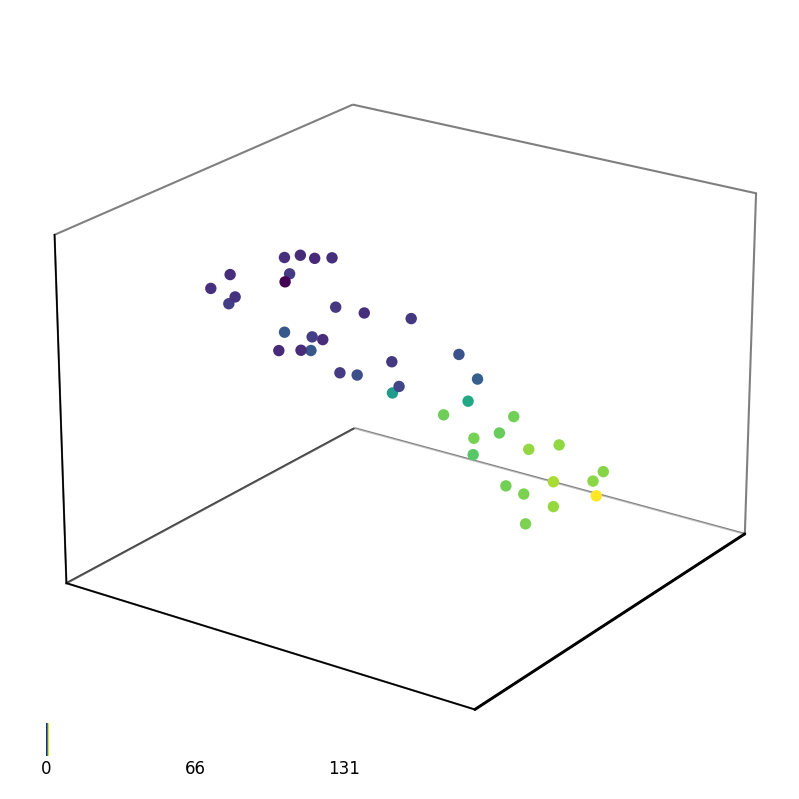

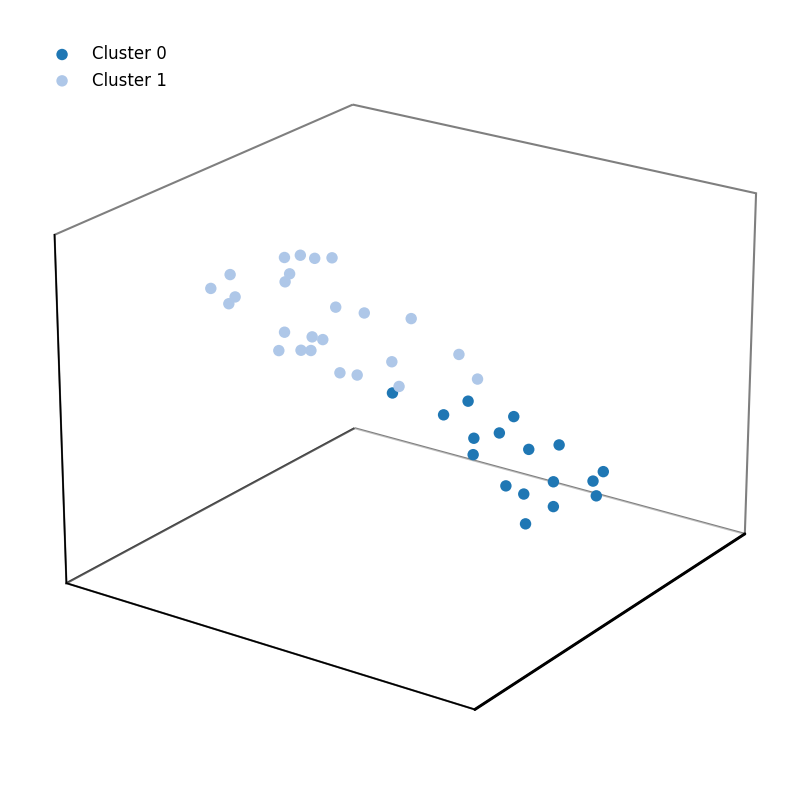

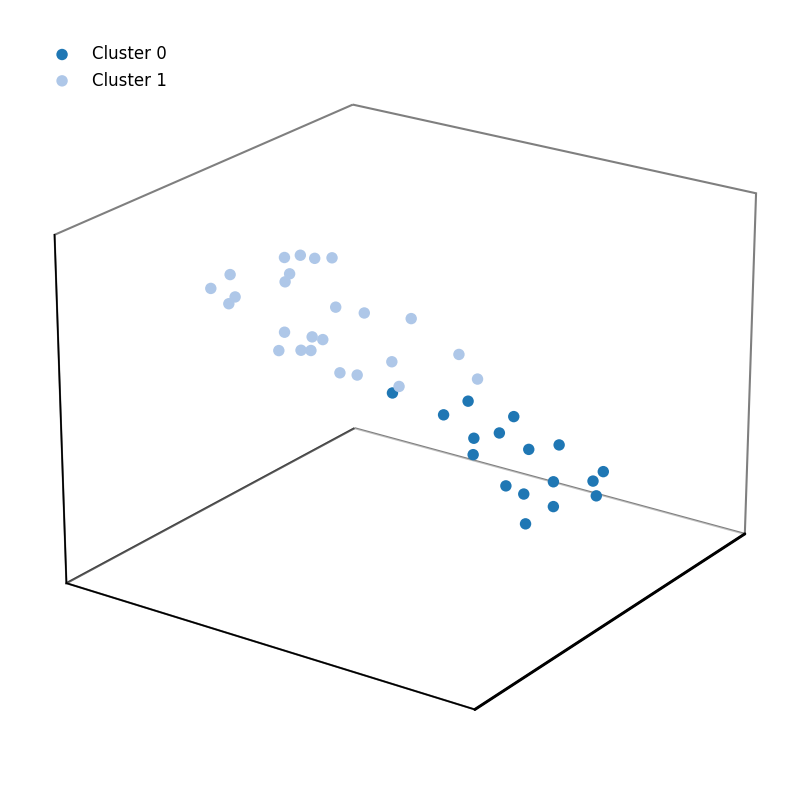

In [59]:
# =========================================================
# 3D UMAP — Minimal Studio Style
# Pseudotime (viridis + colorbar) & KMeans (categorical)
# Con "backline" negra en el fondo para dar profundidad
# =========================================================
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Estética global sobria ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 9
})

# ---------- Utilidades geométricas ----------
def _equal_limits(X: np.ndarray):
    """
    Devuelve (xlim, ylim, zlim) con el mismo rango en los 3 ejes para evitar
    distorsiones en 3D, sin dibujar ningún marco/cubo.
    """
    X = np.asarray(X, float)
    mn = X.min(axis=0); mx = X.max(axis=0)
    ctr = (mn + mx) / 2.0
    span = float(np.max(mx - mn))
    if not np.isfinite(span) or span <= 0:
        span = 1.0
    lo, hi = ctr - span/2, ctr + span/2
    return (lo[0], hi[0]), (lo[1], hi[1]), (lo[2], hi[2])

def _apply_limits_and_view(ax, X, elev=22, azim=35):
    (xmin, xmax), (ymin, ymax), (zmin, zmax) = _equal_limits(X)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.view_init(elev=elev, azim=azim)

# ---------- Pulido estético extremo ----------
def polish_axes_minimal(ax,
                        *,
                        pane_color=(1,1,1,0),   # (1,1,1,0) = pane transparente
                        show_base=False,        # True: base XY suave
                        base_color="#f7f7f7"):
    """
    Elimina bordes, rejilla y ticks. Opcionalmente deja una "base" sutil en XY.
    """
    # Caras/panes sin borde
    ax.xaxis.pane.set_facecolor(pane_color)
    ax.yaxis.pane.set_facecolor(pane_color)
    ax.zaxis.pane.set_facecolor(pane_color)
    for p in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
        try:
            p.set_edgecolor((0,0,0,0))  # sin borde
        except Exception:
            pass

    # Sin rejilla / sin ticks / sin labels
    ax.grid(False)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("")

    # Apagar líneas internas del eje (para que no quede ningún canto)
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        try:
            axis._axinfo["axisline"]["linewidth"] = 0
            axis._axinfo["grid"]["linewidth"] = 0
            axis._axinfo["tick"]["inward_factor"] = 0.0
            axis._axinfo["tick"]["outward_factor"] = 0.0
        except Exception:
            pass

    if show_base:
        # Base XY suave (sin paredes ni techo)
        ax.xaxis.pane.set_facecolor(base_color)
        ax.yaxis.pane.set_facecolor(base_color)
        ax.zaxis.pane.set_facecolor((1,1,1,0))

# ---------- Línea negra del fondo (profundidad) ----------
def add_back_baseline(ax, X, *, color="black", lw=1.4, alpha=1.0):
    """
    Dibuja una línea en el borde trasero del plano XY (y = ymax, z = zmin),
    desde x = xmin hasta x = xmax. No toca el eje Z.
    """
    (xmin, xmax), (ymin, ymax), (zmin, zmax) = _equal_limits(X)
    ax.plot([xmin, xmax], [ymax, ymax], [zmin, zmin],
            color=color, linewidth=lw, alpha=alpha, solid_capstyle="round")

# ---------- Preparador de figura ----------
def _prep_ax_minimal(fig_size=(6.2, 5.4), facecolor="white"):
    fig = plt.figure(figsize=fig_size, facecolor=facecolor)
    ax  = fig.add_subplot(111, projection="3d", facecolor=facecolor)
    return fig, ax

# ---------- Plot: Pseudotime (viridis + colorbar) ----------
def plot_umap3d_pseudotime_minimal(
        emb, pseudotime, *,
        s=28, elev=22, azim=35,
        pane_transparent=True,
        colorbar_pos=(0.12, 0.06, 0.32, 0.04),
        backline=True):
    """
    emb: (n,3) UMAP 3D
    pseudotime: (n,)
    s: tamaño del marcador
    elev/azim: orientación fija
    pane_transparent: True panes invisibles; False panes claros
    colorbar_pos: [left, bottom, width, height] (coords de figura)
    backline: dibuja la raya negra del fondo para profundidad
    """
    emb = np.asarray(emb, float)
    pt  = np.asarray(pseudotime, float)
    if emb.ndim != 2 or emb.shape[1] != 3 or pt.shape[0] != emb.shape[0]:
        raise ValueError("Shapes must be emb(n,3) and pseudotime(n)")

    fig, ax = _prep_ax_minimal()
    _apply_limits_and_view(ax, emb, elev=elev, azim=azim)

    # Color (viridis) normalizado
    pt_norm = (pt - np.nanmin(pt)) / (np.nanmax(pt) - np.nanmin(pt) + 1e-12)
    sc = ax.scatter(
        emb[:,0], emb[:,1], emb[:,2],
        c=pt_norm, cmap="viridis",
        s=s, alpha=1.0, edgecolors="none", depthshade=False
    )

    # Pulido y backline
    pane_col = (1,1,1,0) if pane_transparent else "#f7f7f7"
    polish_axes_minimal(ax, pane_color=pane_col, show_base=False)
    if backline:
        add_back_baseline(ax, emb, color="black", lw=1.4, alpha=1.0)

    # Colorbar horizontal (ticks en escala original)
    cax = fig.add_axes(colorbar_pos)
    cb  = plt.colorbar(sc, cax=cax, orientation="horizontal")
    cb.outline.set_visible(False)
    cb.ax.tick_params(length=0, pad=2, labelsize=8)
    t0, t1 = float(np.nanmin(pt)), float(np.nanmax(pt))
    cb.set_ticks([t0, (t0+t1)/2, t1])
    cb.set_ticklabels([f"{t0:.0f}", f"{(t0+t1)/2:.0f}", f"{t1:.0f}"])

    fig.tight_layout(rect=[0,0,1,1])
    plt.show()
    return fig

# ---------- Plot: KMeans (colores planos + leyenda) ----------
def plot_umap3d_kmeans_minimal(
        emb, labels, *,
        s=28, elev=22, azim=35,
        pane_transparent=True,
        legend_loc=(0.02, 0.98),
        backline=True):
    """
    emb: (n,3) UMAP 3D
    labels: (n,) etiquetas de clúster (int/str)
    s: tamaño del marcador
    elev/azim: orientación fija
    pane_transparent: True panes invisibles; False panes claros
    legend_loc: (x,y) para bbox_to_anchor de la leyenda
    backline: dibuja la raya negra del fondo para profundidad
    """
    emb = np.asarray(emb, float)
    lab = np.asarray(labels)
    if emb.ndim != 2 or emb.shape[1] != 3 or lab.shape[0] != emb.shape[0]:
        raise ValueError("Shapes must be emb(n,3) and labels(n)")

    fig, ax = _prep_ax_minimal()
    _apply_limits_and_view(ax, emb, elev=elev, azim=azim)

    uniq = np.unique(lab)
    base = plt.get_cmap("tab20").colors
    cols = (base * ((len(uniq)//len(base))+1))[:len(uniq)]
    lab2color = {u: cols[i] for i, u in enumerate(uniq)}

    for u in uniq:
        m = (lab == u)
        ax.scatter(
            emb[m,0], emb[m,1], emb[m,2],
            c=[lab2color[u]], s=s, alpha=1.0,
            edgecolors="none", depthshade=False, label=f"Cluster {u}"
        )

    # Pulido y backline
    pane_col = (1,1,1,0) if pane_transparent else "#f7f7f7"
    polish_axes_minimal(ax, pane_color=pane_col, show_base=False)
    if backline:
        add_back_baseline(ax, emb, color="black", lw=1.4, alpha=1.0)

    # Leyenda minimal
    ax.legend(loc="upper left", bbox_to_anchor=legend_loc,
              frameon=False, fontsize=8)

    fig.tight_layout()
    plt.show()
    return fig

# =======================
# EJEMPLO DE USO (comentado)
# =======================
# emb  : np.ndarray (n,3) con coordenadas UMAP 3D
# res  : dict con 'pseudo_time' y 'labels' (si vienes de tu pipeline previo)
pt   = res["pseudo_time"]
labs = res["labels"]

plot_umap3d_pseudotime_minimal(emb, pt, s=30, elev=22, azim=35,
                               pane_transparent=True,
                               colorbar_pos=(0.12, 0.06, 0.32, 0.04),
                               backline=True)

plot_umap3d_kmeans_minimal(emb, labs, s=30, elev=22, azim=35,
                           pane_transparent=True,
                           legend_loc=(0.02, 0.98),
                           backline=True)
